# ChurnInsight Multimodel 

Arquivo gerado a partir de `churninsight_multimodel_vscode.py`.


---


# ChurnInsight – Comparação de Modelos (XGBoost + Random Forest + CatBoost) 📉🤖

Este notebook implementa um **MVP de predição de churn** (cancelamento) para empresas de **serviços recorrentes** (Telecom, Fintech, Streaming, E-commerce).

🎯 **Objetivos**
- Explorar e entender o dataset (EDA) 🔎
- Preparar dados e criar features simples 🧹
- Treinar e comparar **3 algoritmos**:
  - XGBoost (Baseline + Tuned)
  - Random Forest (Baseline + Tuned)
  - CatBoost (Baseline + Tuned)
- Avaliar desempenho com métricas clássicas 📊
- Calibrar threshold (não fixar 0.5) 🎯
- Serializar o **pipeline completo** para uso em uma API 🚀

📦 Dataset: `WA_Fn-UseC_-Telco-Customer-Churn.csv`

<a id="menu"></a>
## Sumário 🧭
1. [Imports e Configuração](#sec-01)
2. [Carregamento dos Dados](#sec-02)
3. [EDA – Análise Exploratória](#sec-03)
4. [Limpeza e Preparação de X e y](#sec-04)
5. [Pré-processamento e Engenharia de Atributos](#sec-05)
6. [Modelos e Pipelines (Baselines)](#sec-06)
7. [Treinamento (Baselines)](#sec-07)
8. [Avaliação (Baselines)](#sec-08)
9. [Serialização dos Pipelines (Baselines)](#sec-09)
10. [Funções de Inferência (Produção/API) — Baseline](#sec-10)
11. [Exemplo de Previsão (Baseline)](#sec-11)
12. [Calibração de Risco (Baixo/Médio/Alto)](#sec-12)
13. [Fine-tune dos Modelos (XGB/RF/CatBoost)](#sec-13)
14. [Serialização dos Artefatos Tunados](#sec-14)
15. [Inferência com Artefatos Tunados](#sec-15)
16. [Relatório Baseline vs Tuned + Comparação entre Algoritmos](#sec-16)
17. [Resumo final (1 slide)](#sec-17)
18. [Storytelling do Hackathon](#sec-18)
19. [Script de Demonstração + Arquitetura](#sec-19)
20. [Texto pronto para README](#sec-20)
21. [Pitch para banca](#sec-21)
22. [Perguntas comuns da banca](#sec-22)
23. [Exemplos de requisição (payloads)](#sec-23)
24. [Testes via cURL](#sec-24)
25. [Padrão de erro + Checklist de demo](#sec-25)

---
[⬆ Voltar ao Sumário](#menu)


---

<a id="sec-01"></a>
## 1. Imports e Configuração ⚙️
Nesta seção, carregamos bibliotecas e configuramos o ambiente para análise e modelagem.

[⬆ Voltar ao Sumário](#menu)

In [92]:
import sys, os, time, warnings
warnings.filterwarnings("ignore")

print("Python:", sys.executable)
print("Versão:", sys.version)

Python: c:\Users\USER\Documents\Repositorios\churninsight-nocountry\venv\Scripts\python.exe
Versão: 3.13.2 (tags/v3.13.2:4f8bb39, Feb  4 2025, 15:23:48) [MSC v.1942 64 bit (AMD64)]


In [93]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
sns.set(style="whitegrid")

from IPython.display import display

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    average_precision_score, precision_recall_curve, roc_curve
)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib

# CatBoost (opcional)
try:
    from catboost import CatBoostClassifier
    CATBOOST_OK = True
except Exception as e:
    CATBOOST_OK = False
    print("⚠️ CatBoost não encontrado. Instale com: pip install catboost")
    print("Detalhe:", repr(e))

pd.set_option("display.max_columns", 80)

<a id="sec-02"></a>
## 2. Carregamento dos Dados 📥
Carregamos o dataset Telco Customer Churn a partir da pasta `data/raw`.

[⬆ Voltar ao Sumário](#menu)

In [94]:
caminho_csv = "../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(caminho_csv)

print("Formato do dataset:", df.shape)
display(df.head())

Formato do dataset: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<a id="sec-03"></a>
## 3. EDA – Análise Exploratória 🔎
Nesta etapa vamos:
- Inspecionar tipos de dados e estrutura 🧾
- Verificar valores ausentes 🕳️
- Analisar a variável alvo (`Churn`) 📌

[⬆ Voltar ao Sumário](#menu)

In [95]:
print("=== Info do DataFrame ===")
df.info()

print("\n=== Estatísticas descritivas (apenas numéricas) ===")
display(df.describe())

print("\n=== Distribuição de Churn (absoluta) ===")
print(df["Churn"].value_counts())

print("\n=== Distribuição de Churn (proporcional) ===")
print(df["Churn"].value_counts(normalize=True))

=== Info do DataFrame ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000



=== Distribuição de Churn (absoluta) ===
Churn
No     5174
Yes    1869
Name: count, dtype: int64

=== Distribuição de Churn (proporcional) ===
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [96]:
# Preparação leve para EDA visual (não altera df original)
df_eda = df.copy()
df_eda["TotalCharges"] = pd.to_numeric(df_eda["TotalCharges"].replace(" ", np.nan), errors="coerce")
df_eda["Churn_bin"] = (df_eda["Churn"] == "Yes").astype(int)

num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
cat_cols_recomendadas = [
    "Contract", "PaymentMethod", "InternetService",
    "OnlineSecurity", "TechSupport", "PaperlessBilling",
    "SeniorCitizen", "Partner", "Dependents"
]

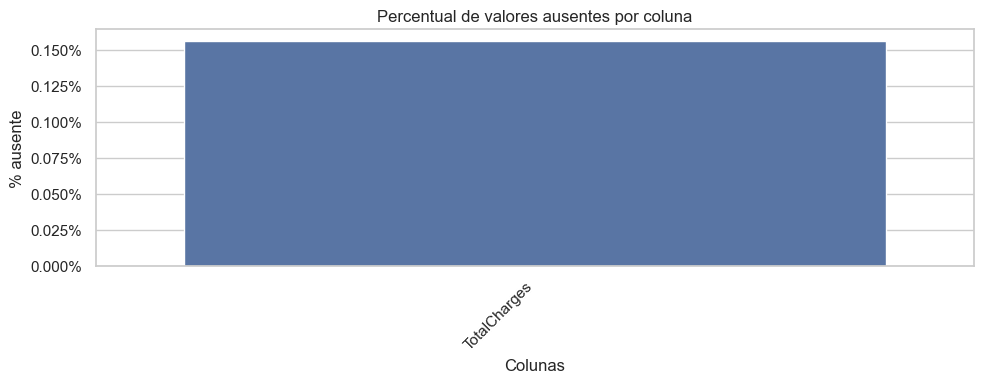

In [97]:
# Missing values por coluna
miss = df_eda.isna().mean().sort_values(ascending=False)
miss = miss[miss > 0]

plt.figure(figsize=(10, 4))
ax = sns.barplot(x=miss.index, y=miss.values)
plt.title("Percentual de valores ausentes por coluna")
plt.ylabel("% ausente")
plt.xlabel("Colunas")
plt.xticks(rotation=45, ha="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

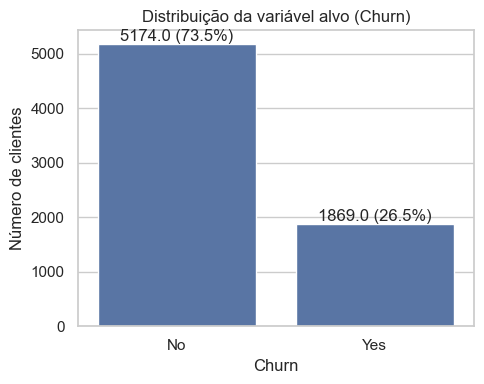

In [98]:
# Distribuição do churn
plt.figure(figsize=(5,4))
ax = sns.countplot(data=df_eda, x="Churn")
plt.title("Distribuição da variável alvo (Churn)")
plt.xlabel("Churn")
plt.ylabel("Número de clientes")

total = len(df_eda)
for p in ax.patches:
    count = p.get_height()
    pct = 100 * count / total
    ax.annotate(f"{count} ({pct:.1f}%)",
                (p.get_x() + p.get_width()/2., count),
                ha="center", va="bottom")
plt.tight_layout()
plt.show()

In [99]:
# Taxa global de churn (baseline de negócio)
CHURN_BASELINE = float(df_eda["Churn_bin"].mean())
print(f"📌 Taxa global de churn no dataset: {CHURN_BASELINE:.2%}")

📌 Taxa global de churn no dataset: 26.54%


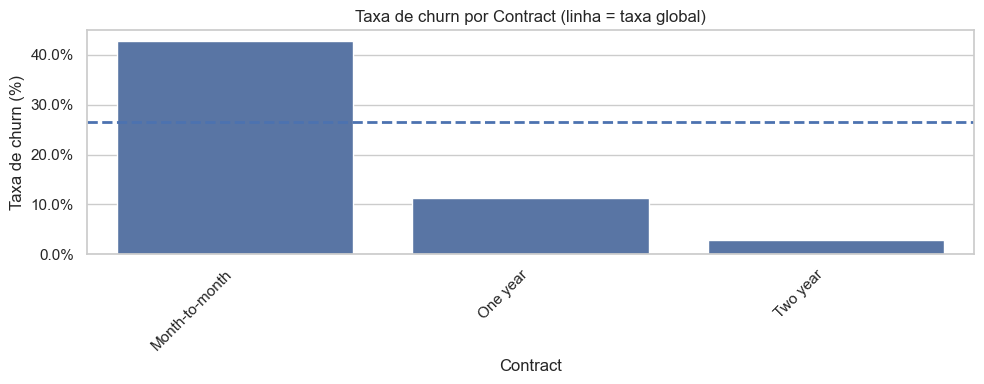

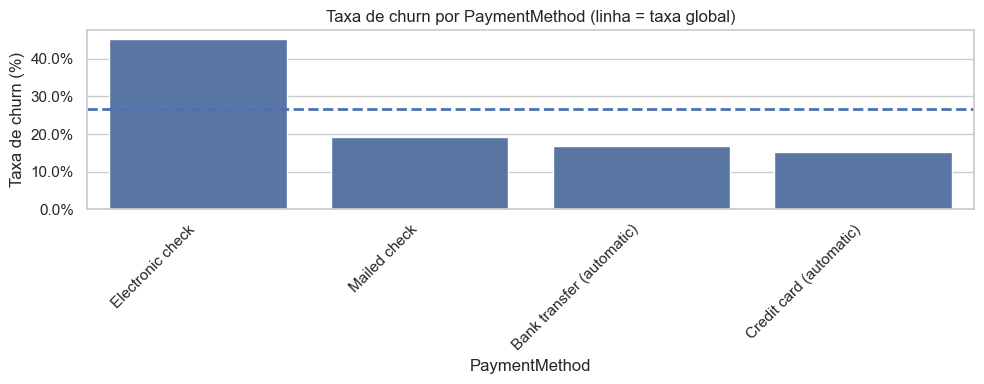

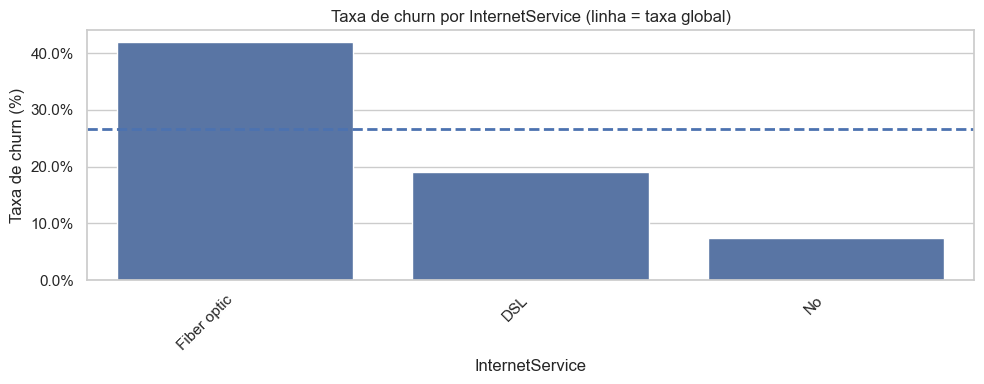

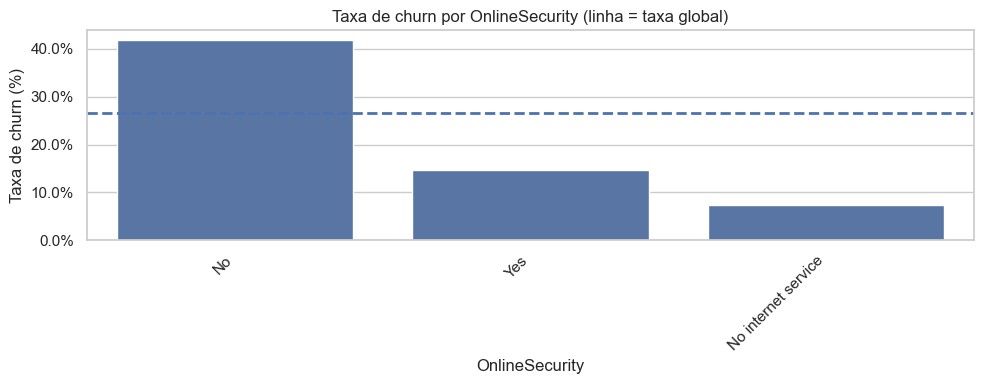

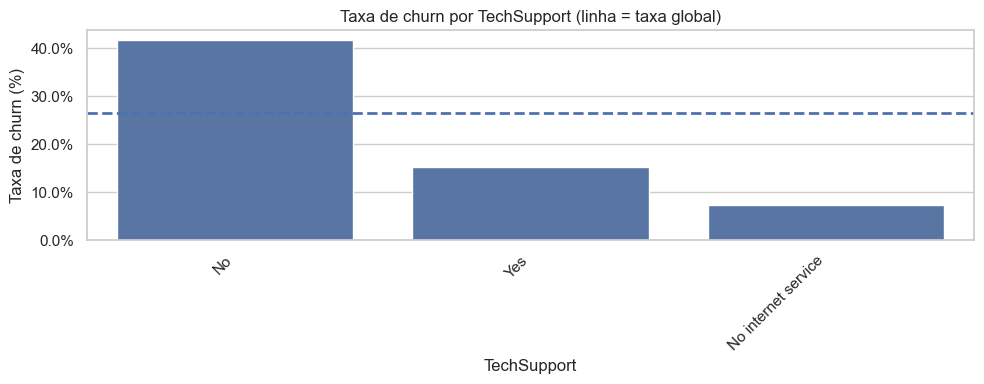

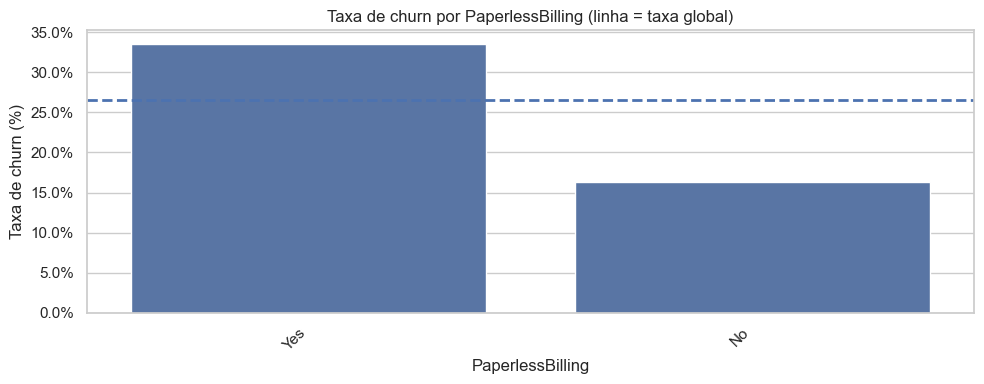

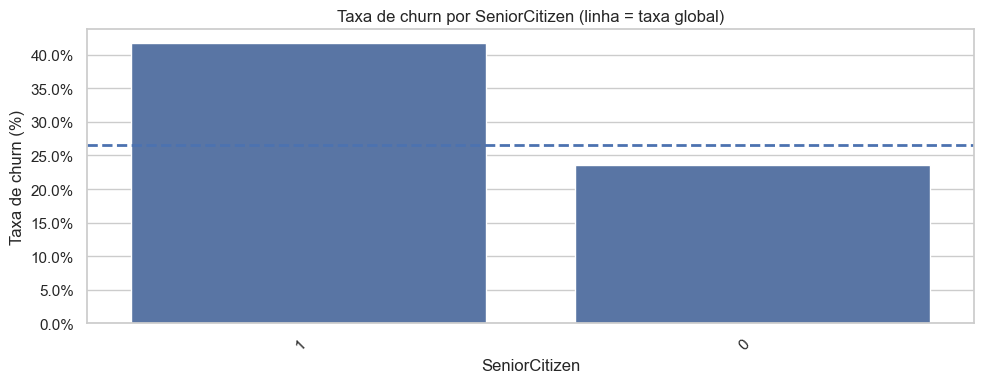

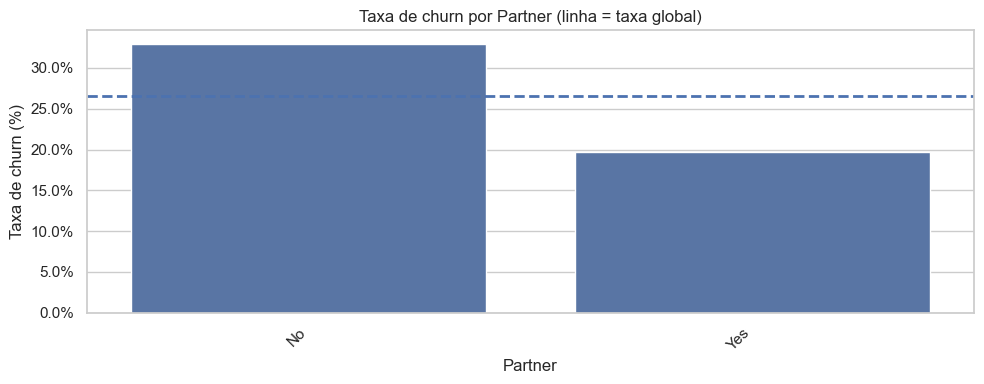

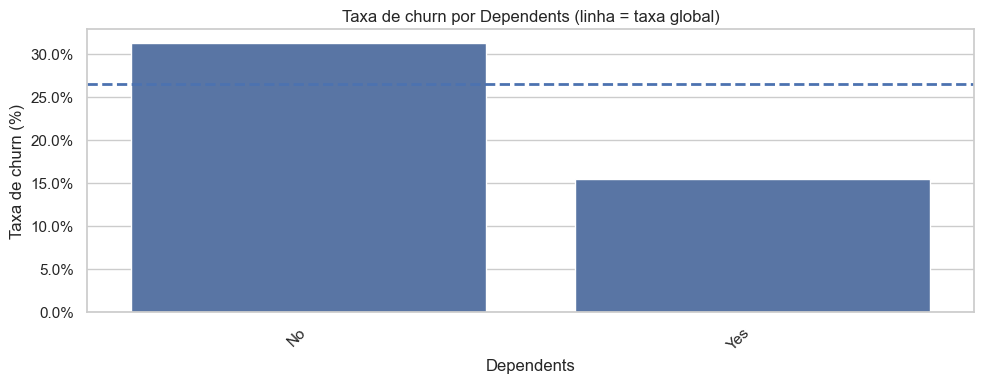

In [100]:
# Churn por variáveis categóricas (taxa %)
def plot_churn_rate_by_cat(df_in, col, top_n=None):
    tmp = df_in[[col, "Churn_bin"]].copy()
    tmp[col] = tmp[col].astype(str)

    if top_n is not None:
        top = tmp[col].value_counts().head(top_n).index
        tmp = tmp[tmp[col].isin(top)]

    rate = (tmp.groupby(col)["Churn_bin"].mean()
            .sort_values(ascending=False)
            .reset_index(name="taxa_churn"))

    plt.figure(figsize=(10, 4))
    ax = sns.barplot(data=rate, x=col, y="taxa_churn")
    ax.axhline(CHURN_BASELINE, linestyle="--", linewidth=2)
    plt.title(f"Taxa de churn por {col} (linha = taxa global)")
    plt.xlabel(col)
    plt.ylabel("Taxa de churn (%)")
    plt.xticks(rotation=45, ha="right")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.tight_layout()
    plt.show()

for c in cat_cols_recomendadas:
    if c in df_eda.columns:
        plot_churn_rate_by_cat(df_eda, c)

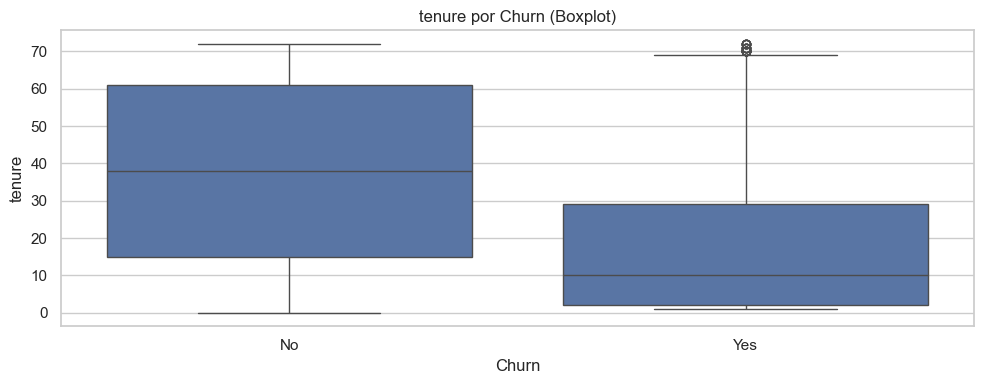

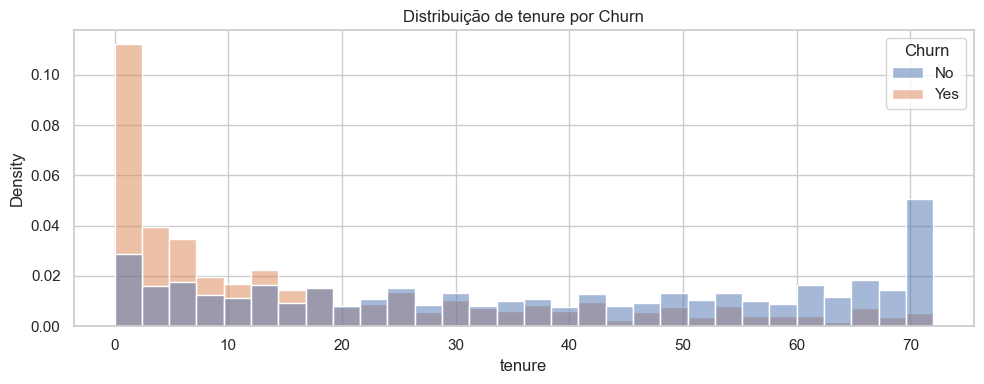

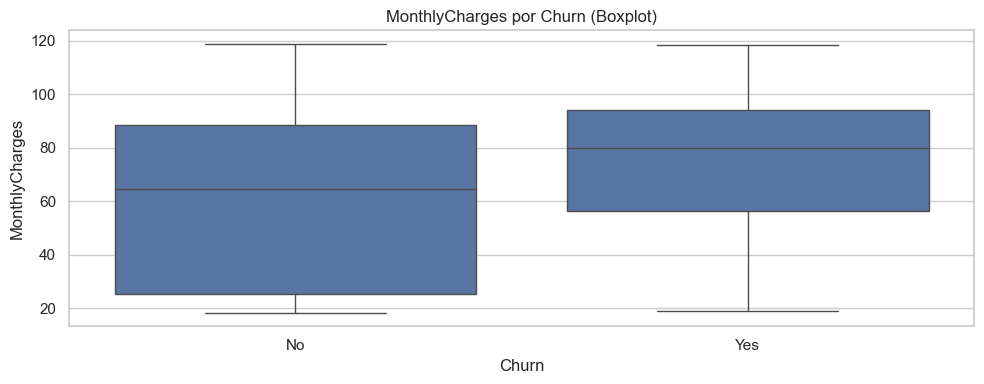

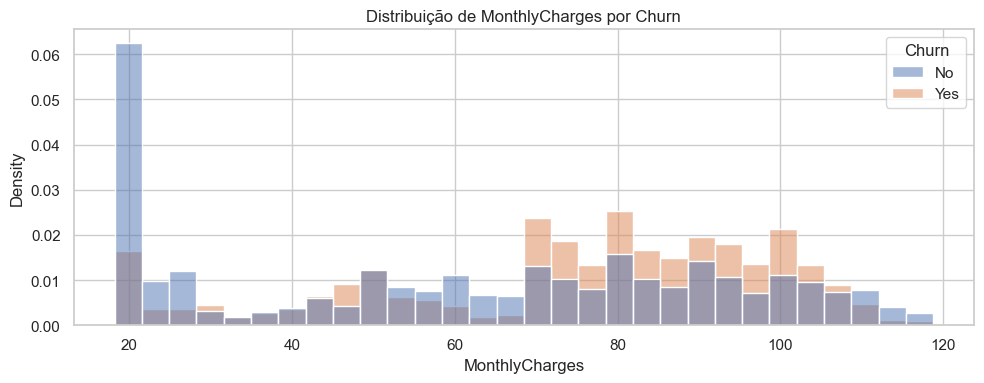

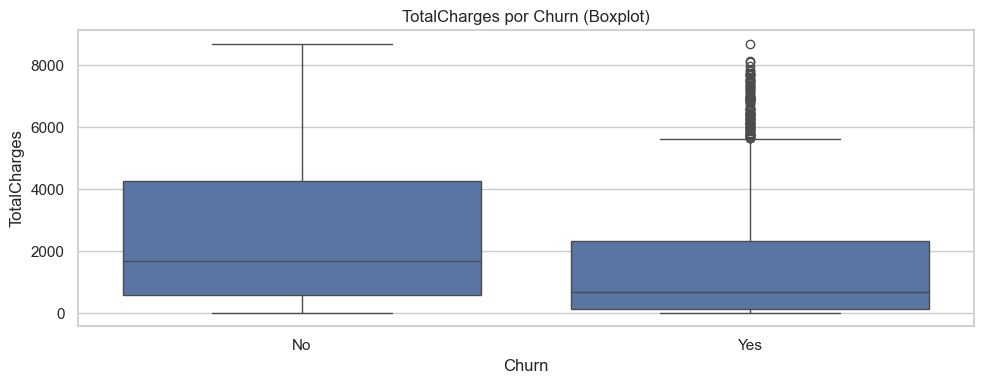

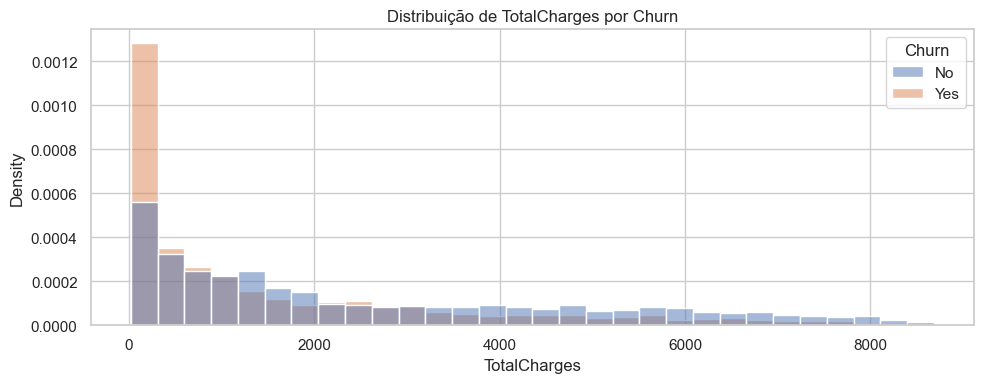

In [101]:
# Distribuições numéricas por churn
def plot_num_by_churn(df_in, col):
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df_in, x="Churn", y=col)
    plt.title(f"{col} por Churn (Boxplot)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.histplot(data=df_in, x=col, hue="Churn", bins=30, stat="density", common_norm=False)
    plt.title(f"Distribuição de {col} por Churn")
    plt.tight_layout()
    plt.show()

for c in num_cols:
    if c in df_eda.columns:
        plot_num_by_churn(df_eda.dropna(subset=[c]), c)

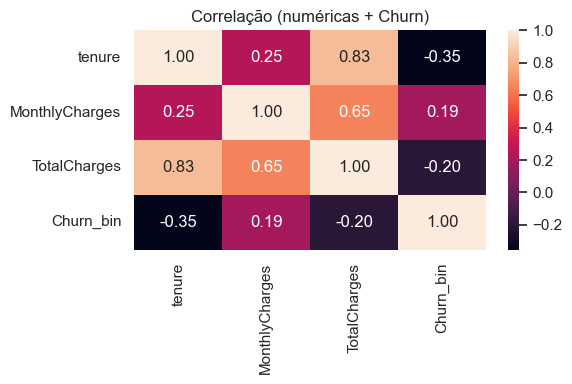

In [102]:
# Correlação simples (numéricas + churn_bin)
corr = df_eda[num_cols + ["Churn_bin"]].corr(numeric_only=True)

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlação (numéricas + Churn)")
plt.tight_layout()
plt.show()

<a id="sec-04"></a>
## 4. Limpeza e Preparação de X e y 🧹
- Converter `TotalCharges` para numérico (há valores vazios como espaço)
- Tratar ausências com mediana
- Separar features (X) e target (y)

[⬆ Voltar ao Sumário](#menu)

In [103]:
df_model = df.copy()

df_model["TotalCharges"] = pd.to_numeric(df_model["TotalCharges"].replace(" ", np.nan), errors="coerce")
df_model["TotalCharges"] = df_model["TotalCharges"].fillna(df_model["TotalCharges"].median())
df_model = df_model.dropna(subset=["Churn"])

y = df_model["Churn"].map({"No": 0, "Yes": 1})
X = df_model.drop(columns=["customerID", "Churn"])

print("✅ Dados prontos.")
print("X shape:", X.shape, "| y mean (taxa churn):", float(y.mean()))

display(X.head())

✅ Dados prontos.
X shape: (7043, 19) | y mean (taxa churn): 0.2653698707936959


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


<a id="sec-05"></a>
## 5. Pré-processamento e Engenharia de Atributos 🧩
- Numéricas: `passthrough`
- Categóricas: `OneHotEncoder(handle_unknown="ignore")`
- Saída densa para compatibilidade com RandomForest/CatBoost

[⬆ Voltar ao Sumário](#menu)

In [104]:
numeric_features = ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]
categorical_features = [c for c in X.columns if c not in numeric_features]

print("Colunas numéricas:", numeric_features)
print("Colunas categóricas (qtd):", len(categorical_features))

def make_ohe():
    # Compatibilidade scikit-learn (sparse_output vs sparse)
    try:
        return OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", make_ohe(), categorical_features),
    ],
    remainder="drop",
)

preprocess

Colunas numéricas: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Colunas categóricas (qtd): 15


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,'first'
,sparse_output,False


<a id="sec-06"></a>
## 6. Modelos e Pipelines (Baselines) 🧠
Criamos 3 pipelines com o **mesmo preprocess**, para comparação justa:
- XGBoost baseline
- Random Forest baseline
- CatBoost baseline (se disponível)


[⬆ Voltar ao Sumário](#menu)

In [105]:
# XGBoost baseline
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
)

clf_xgb = Pipeline(steps=[("preprocess", preprocess), ("model", xgb_model)])

# Random Forest baseline
rf_model = RandomForestClassifier(
    n_estimators=600,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

clf_rf = Pipeline(steps=[("preprocess", preprocess), ("model", rf_model)])

# CatBoost baseline (opcional)
if CATBOOST_OK:
    cb_model = CatBoostClassifier(
        iterations=600,
        depth=6,
        learning_rate=0.05,
        loss_function="Logloss",
        eval_metric="AUC",
        random_seed=42,
        verbose=False,
        auto_class_weights="Balanced",
    )
    clf_cb = Pipeline(steps=[("preprocess", preprocess), ("model", cb_model)])
else:
    clf_cb = None

MODELOS_BASELINE = {
    "xgboost": clf_xgb,
    "random_forest": clf_rf,
}
if clf_cb is not None:
    MODELOS_BASELINE["catboost"] = clf_cb

print("Baselines prontos:", list(MODELOS_BASELINE.keys()))

Baselines prontos: ['xgboost', 'random_forest', 'catboost']


## Pipelines Baseline: XGBoost, Random Forest e CatBoost (comparação justa)

Este trecho de código acima cria **três pipelines de classificação** para churn, todos com o **mesmo pré-processamento (`preprocess`)** e com modelos diferentes. Essa padronização garante uma **comparação justa**, porque a única coisa que muda entre eles é o algoritmo do modelo.

---

## Por que usar `Pipeline(steps=[("preprocess", preprocess), ("model", ...)])`?

- O `Pipeline` encadeia duas etapas:
  - **`preprocess`**: aplica as transformações de dados (ex.: `OneHotEncoder` nas colunas categóricas e `passthrough` nas numéricas).
  - **`model`**: treina e prediz usando o algoritmo (XGBoost, Random Forest ou CatBoost).

- Vantagens práticas:
  - Evita vazamento de dados (o mesmo preprocess usado no treino é aplicado corretamente no teste/inferência).
  - Facilita serialização (salvar e carregar um único objeto com tudo).
  - Mantém consistência em produção (API recebe JSON → vira DataFrame → pipeline trata e prevê).

---

## XGBoost Baseline (`clf_xgb`)

- Modelo (`xgb_model = XGBClassifier(...)`)
  - **`n_estimators=200`**: número de árvores (boosting rounds).
  - **`max_depth=4`**: profundidade máxima das árvores (controla complexidade).
  - **`learning_rate=0.1`**: passo de aprendizado; controla o quanto cada árvore corrige o erro anterior.
  - **`subsample=0.8`**: amostra 80% das linhas por árvore (reduz overfitting).
  - **`colsample_bytree=0.8`**: amostra 80% das colunas por árvore (reduz overfitting).
  - **`objective="binary:logistic"`**: problema binário com saída probabilística (0–1).
  - **`eval_metric="logloss"`**: métrica de avaliação durante o treino (perda logarítmica).
  - **`random_state=42`**: reprodutibilidade.
  - **`n_jobs=-1`**: usa todos os núcleos do CPU (mais rápido).

- Pipeline
  - **`clf_xgb = Pipeline([("preprocess", preprocess), ("model", xgb_model)])`**
  - Resultado: dados entram “crus”, o pipeline transforma e o XGBoost aprende padrões não lineares.

---

## Random Forest Baseline (`clf_rf`)

- Modelo (`rf_model = RandomForestClassifier(...)`)
  - **`n_estimators=600`**: número de árvores na floresta (mais árvores → geralmente mais estabilidade).
  - **`class_weight="balanced"`**: ajusta pesos automaticamente para lidar com **desbalanceamento** (churn costuma ser minoria).
  - **`random_state=42`** e **`n_jobs=-1`**: reprodutibilidade e paralelismo.

- Pipeline
  - **`clf_rf = Pipeline([("preprocess", preprocess), ("model", rf_model)])`**
  - Resultado: compara um modelo de **bagging** (Random Forest) com boosting (XGBoost) usando o mesmo tratamento de dados.

---

## CatBoost Baseline (opcional) (`clf_cb`)

- Por que “opcional”?
  - O CatBoost é importado em um `try/except`. Se a biblioteca não estiver instalada, `CATBOOST_OK=False` e o modelo é **ignorado** sem quebrar o notebook.

- Modelo (`cb_model = CatBoostClassifier(...)`)
  - **`iterations=600`**: número de iterações (árvores) do boosting.
  - **`depth=6`**: profundidade das árvores.
  - **`learning_rate=0.05`**: passo menor (mais conservador; costuma exigir mais iterações).
  - **`loss_function="Logloss"`**: função de perda para classificação binária.
  - **`eval_metric="AUC"`**: métrica reportada durante o treino.
  - **`auto_class_weights="Balanced"`**: balanceamento automático para classe minoritária.
  - **`verbose=False`**: reduz logs.
  - **`random_seed=42`**: reprodutível.

- Pipeline
  - **`clf_cb = Pipeline([("preprocess", preprocess), ("model", cb_model)])`**
  - Observação: o CatBoost é reconhecido por bom desempenho em dados tabulares e costuma ser um competidor forte em churn.

---

## Dicionário final de modelos (`MODELOS_BASELINE`)

- O código abaixo mantém todos os pipelines organizados em um único objeto:
  ```python
  MODELOS_BASELINE = {
      "xgboost": clf_xgb,
      "random_forest": clf_rf,
  }
  if clf_cb is not None:
      MODELOS_BASELINE["catboost"] = clf_cb


<a id="sec-07"></a>
## 7. Treinamento (Baselines) 🏋️
Separamos treino e teste com `stratify=y` para manter a proporção de churn.

### `train_test_split(X, y, ...)`

Divide as **features** (`X`) e o **target** (`y`) em dois subconjuntos:

- **`X_train`, `y_train`**: usados para **treinar** o modelo.  
- **`X_test`, `y_test`**: usados para **testar** o modelo em dados “novos”, simulando produção.

---

### `test_size=0.2`

Reserva **20%** dos dados para **teste** e mantém **80%** para **treino**.

---

### `random_state=42`

Define uma **semente fixa** para a aleatoriedade da divisão.  
Resultado: a separação fica **reprodutível** (ao rodar novamente, a divisão sai igual).

---

### `stratify=y`

Garante que a **proporção das classes** no target (ex.: `churn=1` vs `não churn=0`) fique **semelhante** no treino e no teste.

Isso é especialmente importante em churn, onde geralmente há **desbalanceamento** (menos casos de churn do que não churn). Sem estratificação, o conjunto de teste pode ficar “tendencioso” (com churn demais ou de menos), reduzindo a confiabilidade das métricas.

---

### `print("Tamanho treino:", X_train.shape)` e `print("Tamanho teste :", X_test.shape)`

Confirma, via console, **quantas linhas/colunas** foram para treino e teste.  
O `shape` retorna **`(linhas, colunas)`** para `X_*`.


[⬆ Voltar ao Sumário](#menu)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print("Tamanho treino:", X_train.shape)
print("Tamanho teste :", X_test.shape)

Tamanho treino: (5634, 19)
Tamanho teste : (1409, 19)


In [107]:
baseline_fit = {}
for nome, pipe in MODELOS_BASELINE.items():
    t0 = time.time()
    pipe.fit(X_train, y_train)
    baseline_fit[nome] = pipe
    print(f"✅ Treinamento baseline concluído: {nome} ({time.time()-t0:.1f}s)")

✅ Treinamento baseline concluído: xgboost (0.1s)
✅ Treinamento baseline concluído: random_forest (0.8s)
✅ Treinamento baseline concluído: catboost (1.7s)


<a id="sec-08"></a>
## 8. Avaliação (Baselines) 📊
Calculamos métricas e comparamos os modelos no **mesmo conjunto de teste**.
Incluímos **PR-AUC**, recomendada para churn (classe positiva desbalanceada).

[⬆ Voltar ao Sumário](#menu)

In [108]:
def avaliar_modelo(y_true, proba, threshold=0.5):
    pred = (proba >= threshold).astype(int)
    return {
        "threshold": float(threshold),
        "accuracy": float(accuracy_score(y_true, pred)),
        "precision": float(precision_score(y_true, pred, zero_division=0)),
        "recall": float(recall_score(y_true, pred, zero_division=0)),
        "f1": float(f1_score(y_true, pred, zero_division=0)),
        "roc_auc": float(roc_auc_score(y_true, proba)),
        "pr_auc": float(average_precision_score(y_true, proba)),
    }

def escolher_threshold_max_f1(y_true, proba, grid=np.linspace(0.05, 0.95, 91)):
    melhor_thr, melhor_f1 = 0.5, -1
    for thr in grid:
        pred = (proba >= thr).astype(int)
        f1 = f1_score(y_true, pred, zero_division=0)
        if f1 > melhor_f1:
            melhor_f1 = f1
            melhor_thr = float(thr)
    return melhor_thr, melhor_f1

In [109]:
# Avaliação baseline em tabela (thr=0.50)
rows = []
y_proba_baselines = {}

for nome, pipe in baseline_fit.items():
    proba = pipe.predict_proba(X_test)[:, 1]
    y_proba_baselines[nome] = proba
    m = avaliar_modelo(y_test, proba, threshold=0.50)
    rows.append({"modelo": f"{nome} baseline (thr=0.50)", **m})

df_baselines = pd.DataFrame(rows).sort_values("pr_auc", ascending=False)
display(df_baselines)

,modelo,threshold,accuracy,precision,recall,f1,roc_auc,pr_auc
0,xgboost baseline (thr=0.50),0.5,0.799148,0.650165,0.526738,0.581979,0.840404,0.648437
2,catboost baseline (thr=0.50),0.5,0.757984,0.532673,0.719251,0.612059,0.836866,0.647890
1,random_forest baseline (thr=0.50),0.5,0.787793,0.627119,0.494652,0.553064,0.825281,0.621884


## Leitura da tabela de métricas (Baselines com threshold = 0.50)

A tabela acima resume o desempenho dos **modelos baseline** avaliados no mesmo conjunto de teste, usando **threshold fixo de 0,50** (isto é, probabilidade ≥ 0,50 ⇒ “vai cancelar”).

---

## O que significa cada coluna

- **modelo**
  - Identifica o algoritmo e a configuração avaliada (ex.: `xgboost baseline (thr=0.50)`).

- **threshold**
  - Corte aplicado para converter probabilidade em classe.
  - Ex.: `0.50` significa que `proba >= 0.50` vira churn (classe 1).

- **accuracy**
  - Proporção total de acertos (churn + não churn).
  - Boa para visão geral, mas pode ser enganosa em problemas desbalanceados.

- **precision**
  - Entre os clientes que o modelo **marcou como churn**, quantos realmente churnaram.
  - Alta precision reduz **falsos positivos** (acionar retenção para quem não iria cancelar).

- **recall**
  - Entre os clientes que **realmente churnaram**, quantos o modelo conseguiu capturar.
  - Alto recall reduz **falsos negativos** (deixar passar churners).

- **f1**
  - Média harmônica entre precision e recall.
  - Útil quando você quer equilíbrio entre “não desperdiçar ações” (precision) e “não perder churners” (recall).

- **roc_auc**
  - Mede capacidade de separação entre classes em vários thresholds.
  - Bom indicador global, mas pode ser menos sensível que PR-AUC quando a classe positiva é rara.

- **pr_auc**
  - Área sob a curva Precision–Recall.
  - Geralmente **mais apropriada para churn** (classe positiva desbalanceada), pois foca no trade-off entre precision e recall.

---

## Interpretação dos resultados desta execução

- **XGBoost (baseline, thr=0.50)**
  - Melhor **accuracy** (0.799) e melhor **pr_auc** (0.648) nesta rodada.
  - Recall mais baixo (0.527) sugere que, com thr=0.50, ele é mais conservador na captura de churn.

- **CatBoost (baseline, thr=0.50)**
  - Melhor **recall** (0.719) e melhor **f1** (0.612) entre os baselines.
  - Indica maior capacidade de capturar churners, possivelmente com maior custo de falsos positivos (precision 0.533).

- **Random Forest (baseline, thr=0.50)**
  - Menor **pr_auc** (0.622) e recall (0.495) entre os três.
  - Nesta configuração baseline, ficou atrás dos modelos de boosting para o objetivo de churn.

---



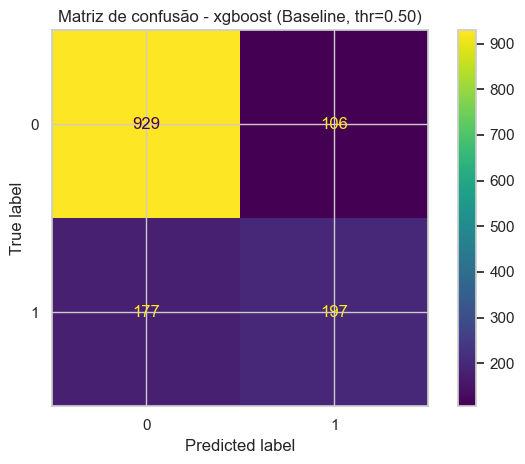

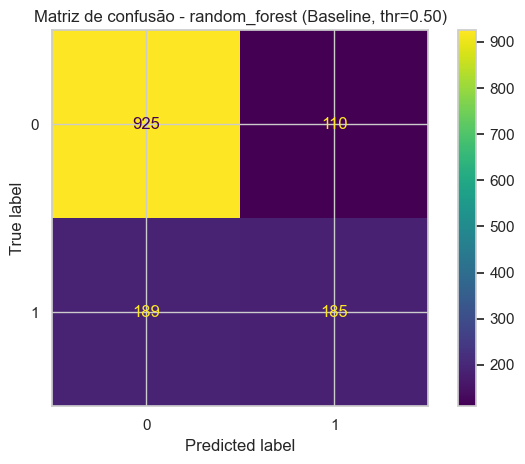

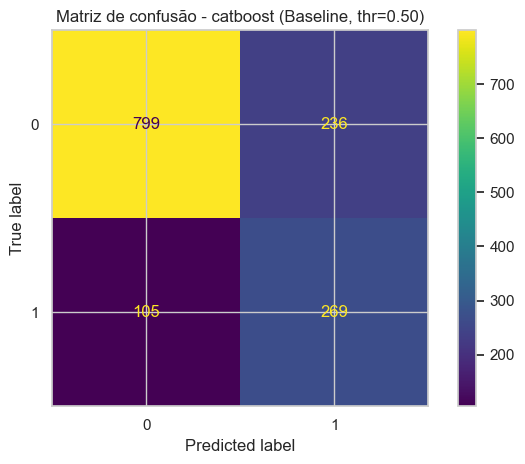

In [110]:
# Matrizes de confusão (baseline thr=0.50)
for nome in baseline_fit.keys():
    pipe = baseline_fit[nome]
    proba = y_proba_baselines[nome]
    pred = (proba >= 0.50).astype(int)

    disp = ConfusionMatrixDisplay.from_predictions(y_test, pred)
    plt.title(f"Matriz de confusão - {nome} (Baseline, thr=0.50)")
    plt.tight_layout()
    plt.show()

## Como ler uma matriz de confusão 

A matriz de confusão é uma tabela 2×2 que cruza:

- **Real (y_test)**: o que de fato aconteceu.
- **Previsto (pred)**: o que o modelo disse que aconteceria.

No caso (churn binário), normalmente:
- **0 = não churn** (“Vai continuar”)
- **1 = churn** (“Vai cancelar”)

### Estrutura típica (scikit-learn)

Em geral, a matriz aparece como:

|                | **Previsto 0** (continuar) | **Previsto 1** (cancelar) |
|---|---:|---:|
| **Real 0** (continuar) | **TN** | **FP** |
| **Real 1** (cancelar)  | **FN** | **TP** |

> Dica: a **linha** costuma ser o *real* e a **coluna** o *previsto* (esse é o padrão da matriz retornada pelo scikit-learn).

### O que significa cada quadrante

- **TN (True Negative)** — Real 0, Previsto 0  
  Clientes que **não cancelariam** e o modelo **acertou** (“vai continuar”).

- **FP (False Positive)** — Real 0, Previsto 1  
  Clientes que **não cancelariam**, mas o modelo **alarmou churn** (“vai cancelar”).  
  **Impacto no negócio:** ações de retenção desnecessárias (custo operacional).

- **FN (False Negative)** — Real 1, Previsto 0  
  Clientes que **cancelariam**, mas o modelo **não detectou** (“vai continuar”).  
  **Impacto no negócio:** churn “perdido” (maior prejuízo típico).

- **TP (True Positive)** — Real 1, Previsto 1  
  Clientes que **cancelariam** e o modelo **detectou** (“vai cancelar”).  
  **Impacto no negócio:** oportunidade de retenção (valor direto).

### Como extrair os insights principais em churn

- Se você quer **capturar mais churners**, olhe para **FN**:
  - **Quanto menor o FN**, melhor (você está deixando menos cancelamentos passarem).
  - Reduzir FN geralmente aumenta **Recall**.

- Se você quer **evitar gastar esforço com clientes que não iriam churnar**, olhe para **FP**:
  - **Quanto menor o FP**, melhor (menos falsos alarmes).
  - Reduzir FP geralmente aumenta **Precision**.

### Ligando a matriz às métricas (interpretando rapidamente)

- **Recall (sensibilidade)** foca em “dos churners reais, quantos eu peguei?”
  - `Recall = TP / (TP + FN)`
  - Se **FN** estiver alto, o recall cai.

- **Precision** foca em “dos que eu marquei como churn, quantos eram mesmo churn?”
  - `Precision = TP / (TP + FP)`
  - Se **FP** estiver alto, a precision cai.

### Como o threshold (0.50) afeta a matriz

No código utilizamos `pred = (proba >= 0.50)`. Isso significa:

- Se  **baixar o threshold** (ex.: 0.40):
  - tende a aumentar previsões de churn → **TP sobe**, mas **FP também pode subir**
  - geralmente **FN diminui** (bom para recall)

- Se  **subir o threshold** (ex.: 0.70):
  - tende a reduzir previsões de churn → **FP cai**, mas **FN pode subir**
  - geralmente **precision melhora**, mas **recall pode cair**

### Checklist de leitura (para apresentar na banca)

- Identifique o que é **classe positiva** (churn=1).
- Compare **FN vs FP** com foco no custo do negócio.
- Justifique o threshold conforme o objetivo:
  - **minimizar FN** (não perder churn) vs **minimizar FP** (não gastar esforço à toa).


<a id="sec-09"></a>
## 9. Serialização dos Pipelines (Baselines) 💾
Salvamos os pipelines baseline para uso em produção/API.

[⬆ Voltar ao Sumário](#menu)

In [111]:
os.makedirs("../model", exist_ok=True)

paths_baseline = {}
for nome, pipe in baseline_fit.items():
    out = f"../model/churn_{nome}_pipeline.joblib"
    joblib.dump(pipe, out)
    paths_baseline[nome] = out
    print(f"✅ Pipeline baseline salvo: {nome} -> {out}")

✅ Pipeline baseline salvo: xgboost -> ../model/churn_xgboost_pipeline.joblib
✅ Pipeline baseline salvo: random_forest -> ../model/churn_random_forest_pipeline.joblib
✅ Pipeline baseline salvo: catboost -> ../model/churn_catboost_pipeline.joblib


<a id="sec-10"></a>
## 10. Funções de Inferência (Produção/API) — Baseline 🧪
Funções utilitárias para:
- carregar modelo baseline
- validar entrada
- retornar `{previsao, probabilidade}` no formato esperado pela API

[⬆ Voltar ao Sumário](#menu)

In [112]:
def carregar_modelo_baseline(nome_modelo: str = "xgboost"):
    if nome_modelo not in paths_baseline:
        raise ValueError(f"Modelo baseline desconhecido: {nome_modelo}. Opções: {list(paths_baseline.keys())}")
    return joblib.load(paths_baseline[nome_modelo])

def prever_cliente_baseline(dados_cliente: dict, nome_modelo: str = "xgboost", modelo=None, threshold: float = 0.5):
    if modelo is None:
        modelo = carregar_modelo_baseline(nome_modelo)

    X_novo = pd.DataFrame([dados_cliente])

    colunas_esperadas = list(X.columns)
    faltando = set(colunas_esperadas) - set(X_novo.columns)
    sobrando = set(X_novo.columns) - set(colunas_esperadas)

    if faltando:
        raise ValueError(f"❌ Faltam colunas na entrada: {sorted(list(faltando))}")
    if sobrando:
        raise ValueError(f"❌ Existem colunas não reconhecidas: {sorted(list(sobrando))}")

    X_novo = X_novo[colunas_esperadas]

    prob = float(modelo.predict_proba(X_novo)[:, 1][0])
    pred = int(prob >= threshold)

    return {
        "modelo": nome_modelo,
        "previsao": "Vai cancelar" if pred == 1 else "Vai continuar",
        "probabilidade": prob,
        "threshold_usado": float(threshold),
    }

## Funções de inferência (Baseline) — carregamento e previsão

Este bloco implementa duas funções utilitárias para **uso em produção / API** com os modelos *baseline* serializados (arquivos `.joblib`). O objetivo é padronizar:

- **Carregamento do pipeline** treinado (pré-processamento + modelo)
- **Validação do payload** de entrada (campos obrigatórios e campos extras)
- **Inferência** retornando uma saída consistente: `{previsao, probabilidade, threshold_usado}`

---

### `carregar_modelo_baseline(nome_modelo: str = "xgboost")`

Carrega do disco o pipeline baseline correspondente ao algoritmo escolhido.

- **Entrada**
  - `nome_modelo`: chave do dicionário `paths_baseline` (ex.: `"xgboost"`, `"random_forest"`, `"catboost"`).

- **Validação**
  - Se `nome_modelo` não existir em `paths_baseline`, a função interrompe o fluxo com `ValueError`,
    prevenindo tentativas de carregar modelos inexistentes ou nomes digitados incorretamente.

- **Saída**
  - Retorna o objeto carregado via `joblib.load(...)`, que é o **pipeline completo** (incluindo o `preprocess` e o `model`).

> Benefício: garante que a inferência use exatamente o mesmo pré-processamento aplicado no treino, reduzindo risco de inconsistência em produção.

---

### `prever_cliente_baseline(dados_cliente: dict, nome_modelo: str = "xgboost", modelo=None, threshold: float = 0.5)`

Executa uma previsão de churn a partir de um **payload JSON** (dicionário Python), aplicando validações mínimas de schema.

- **Entradas**
  - `dados_cliente`: dicionário com as features do cliente (mesmas colunas de `X` no treino).
  - `nome_modelo`: qual baseline usar (padrão: `"xgboost"`).
  - `modelo`: opcional; se você já tiver o pipeline carregado em memória, pode passar aqui para evitar reload do disco.
  - `threshold`: cutoff para converter probabilidade em classe (padrão: `0.5`).

---

## Fluxo de execução (passo a passo)

- **Carregamento do modelo**
  - Se `modelo is None`, chama `carregar_modelo_baseline(nome_modelo)`.
  - Isso permite dois cenários:
    - *Uso simples*: a função carrega o modelo automaticamente.
    - *Uso otimizado*: a aplicação carrega uma vez e reutiliza (melhor para API).

- **Criação do “batch” de inferência**
  - `X_novo = pd.DataFrame([dados_cliente])`
  - Converte o payload em um DataFrame com 1 linha, mantendo compatibilidade com o pipeline do scikit-learn.

- **Validação do schema de entrada**
  - Define o schema esperado com `colunas_esperadas = list(X.columns)`.
  - Calcula:
    - `faltando`: colunas que existem no treino mas não vieram no payload.
    - `sobrando`: colunas que vieram no payload mas não existem no treino.
  - Se houver qualquer inconsistência, dispara `ValueError` com mensagem explícita.

> Benefício: evita previsões “silenciosamente erradas” por payload incompleto ou com campos inválidos.

- **Ordenação das colunas**
  - `X_novo = X_novo[colunas_esperadas]`
  - Garante que a ordem das features siga exatamente o padrão esperado pelo pipeline.

- **Inferência probabilística**
  - `prob = float(modelo.predict_proba(X_novo)[:, 1][0])`
  - Obtém a probabilidade da **classe positiva (churn = 1)**.

- **Decisão por threshold**
  - `pred = int(prob >= threshold)`
  - Converte a probabilidade em rótulo binário:
    - `1` → churn (cliente deve cancelar)
    - `0` → não churn (cliente deve continuar)

---

## Retorno padronizado (contrato de saída)

A função retorna um dicionário pronto para ser serializado em JSON:

- `modelo`: algoritmo utilizado (ex.: `"xgboost"`)
- `previsao`: texto legível para demo (*"Vai cancelar"* ou *"Vai continuar"*)
- `probabilidade`: score numérico (0 a 1) associado à classe churn
- `threshold_usado`: cutoff aplicado na decisão

> Benefício: facilita integração com FastAPI/Streamlit, pois a resposta já está no formato de “produto”, não apenas em rótulos numéricos.


<a id="sec-11"></a>
## 11. Exemplo de Previsão (Baseline) 🧾
[⬆ Voltar ao Sumário](#menu)

In [113]:
exemplo_cliente = {
    "gender": "Female",
    "SeniorCitizen": 0,
    "Partner": "Yes",
    "Dependents": "No",
    "tenure": 12,
    "PhoneService": "Yes",
    "MultipleLines": "No",
    "InternetService": "Fiber optic",
    "OnlineSecurity": "No",
    "OnlineBackup": "Yes",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "Yes",
    "StreamingMovies": "No",
    "Contract": "Month-to-month",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Electronic check",
    "MonthlyCharges": 70.35,
    "TotalCharges": 151.65,
}

print(prever_cliente_baseline(exemplo_cliente, nome_modelo="xgboost", threshold=0.50))

{'modelo': 'xgboost', 'previsao': 'Vai continuar', 'probabilidade': 0.476134717464447, 'threshold_usado': 0.5}


<a id="sec-12"></a>
## 12. Calibração de Risco (Baixo/Médio/Alto) 🚦
A ideia aqui é transformar a probabilidade em faixas de risco para o negócio.

[⬆ Voltar ao Sumário](#menu)

In [114]:
# Escolha qual baseline usar para calibração (para comparação, use o mesmo padrão, ex.: xgboost)
MODELO_RISCO = "xgboost"

y_proba_risco = baseline_fit[MODELO_RISCO].predict_proba(X_test)[:, 1]

df_eval = pd.DataFrame({
    "y_true": y_test.values,
    "prob_churn": y_proba_risco
})

display(df_eval.head())

,y_true,prob_churn
0,0,0.005064
1,0,0.897503
2,0,0.108434
3,0,0.327762
4,0,0.004445


In [115]:
bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]

df_eval["prob_bin"] = pd.cut(df_eval["prob_churn"], bins=bins, labels=labels, include_lowest=True)
dist_prob = df_eval["prob_bin"].value_counts().sort_index()
print("=== Distribuição de clientes por faixa de probabilidade ===")
print(dist_prob)

=== Distribuição de clientes por faixa de probabilidade ===
prob_bin
0–0.2      767
0.2–0.4    215
0.4–0.6    217
0.6–0.8    143
0.8–1.0     67
Name: count, dtype: int64


In [116]:
stats_bins = (
    df_eval
    .groupby("prob_bin")
    .agg(total_clientes=("y_true", "count"), churns_reais=("y_true", "sum"))
)
stats_bins["taxa_churn_real"] = stats_bins["churns_reais"] / stats_bins["total_clientes"]
display(stats_bins)

,total_clientes,churns_reais,taxa_churn_real
prob_bin,,,
0–0.2,767,64,0.083442
0.2–0.4,215,60,0.279070
0.4–0.6,217,103,0.474654
0.6–0.8,143,93,0.650350
0.8–1.0,67,54,0.805970


In [117]:
def classificar_risco(prob, thr_medio, thr_alto):
    if prob >= thr_alto:
        return "alto"
    elif prob >= thr_medio:
        return "medio"
    else:
        return "baixo"

thresholds_medio = [0.3, 0.4, 0.5]
thresholds_alto  = [0.6, 0.7, 0.8]

resultados = []
for thr_m in thresholds_medio:
    for thr_a in thresholds_alto:
        if thr_a <= thr_m:
            continue

        df_tmp = df_eval.copy()
        df_tmp["risco"] = df_tmp["prob_churn"].apply(lambda p: classificar_risco(p, thr_m, thr_a))

        resumo = (
            df_tmp
            .groupby("risco")
            .agg(total_clientes=("y_true", "count"), churns_reais=("y_true", "sum"))
        )
        resumo["taxa_churn_real"] = resumo["churns_reais"] / resumo["total_clientes"]

        resultados.append({
            "thr_medio": thr_m,
            "thr_alto": thr_a,
            "total_alto": int(resumo.loc["alto", "total_clientes"]) if "alto" in resumo.index else 0,
            "taxa_alto": float(resumo.loc["alto", "taxa_churn_real"]) if "alto" in resumo.index else np.nan,
            "total_medio": int(resumo.loc["medio", "total_clientes"]) if "medio" in resumo.index else 0,
            "taxa_medio": float(resumo.loc["medio", "taxa_churn_real"]) if "medio" in resumo.index else np.nan,
            "total_baixo": int(resumo.loc["baixo", "total_clientes"]) if "baixo" in resumo.index else 0,
            "taxa_baixo": float(resumo.loc["baixo", "taxa_churn_real"]) if "baixo" in resumo.index else np.nan,
        })

df_thresholds = pd.DataFrame(resultados)
display(df_thresholds.sort_values("taxa_alto", ascending=False).head(10))

,thr_medio,thr_alto,total_alto,taxa_alto,total_medio,taxa_medio,total_baixo,taxa_baixo
2,0.3,0.8,67,0.805970,466,0.487124,876,0.106164
8,0.5,0.8,67,0.805970,236,0.605932,1106,0.160036
5,0.4,0.8,67,0.805970,360,0.544444,982,0.126273
7,0.5,0.7,139,0.748201,164,0.567073,1106,0.160036
1,0.3,0.7,139,0.748201,394,0.449239,876,0.106164
4,0.4,0.7,139,0.748201,288,0.506944,982,0.126273
0,0.3,0.6,210,0.700000,323,0.414861,876,0.106164
3,0.4,0.6,210,0.700000,217,0.474654,982,0.126273
6,0.5,0.6,210,0.700000,93,0.537634,1106,0.160036


## Acima temos a Tabela de calibração de risco (Baixo / Médio / Alto) por thresholds

Esta tabela resume como diferentes combinações de **thresholds** transformam a probabilidade prevista de churn (`prob_churn`) em **faixas de risco**:

- **baixo**: `prob_churn < thr_medio`
- **médio**: `thr_medio ≤ prob_churn < thr_alto`
- **alto**: `prob_churn ≥ thr_alto`

Para cada combinação de thresholds, a tabela mostra **quantos clientes** caem em cada faixa e **qual é a taxa real de churn** dentro daquela faixa.

---

## O que significa cada coluna

- **thr_medio**: limite mínimo para um cliente ser considerado **risco médio**.
- **thr_alto**: limite mínimo para um cliente ser considerado **risco alto**.
- **total_alto / total_medio / total_baixo**: quantidade de clientes classificados em cada faixa.
- **taxa_alto / taxa_medio / taxa_baixo**: churn real observado dentro de cada faixa  
  (ex.: `taxa_alto = 0.805970` significa que ~80,6% dos clientes classificados como “alto” realmente churnaram).

---

## Como interpretar (o “ideal” do ponto de vista do negócio)

Em geral, queremos:

- **taxa_alto alta**: o topo da fila (alto risco) realmente concentra churn (boa priorização).
- **taxa_baixo baixa**: a base (baixo risco) tem poucos churners (evita gastar esforço onde não precisa).
- **total_alto compatível com a capacidade operacional**: quantos clientes o time consegue contatar/retener.

A tabela justamente permite escolher thresholds que equilibram **qualidade do público-alvo** e **volume**.

---

## Leitura dos principais cenários da tabela

### Quando `thr_alto = 0.8` (alto risco bem “seletivo”)
Linhas (0.3/0.8), (0.4/0.8), (0.5/0.8):

- **total_alto = 67** em todos os casos (porque o corte de “alto” é bem alto)
- **taxa_alto = 0.805970** (~80,6% churn real) → **excelente pureza do alto risco**
- O que muda é como você divide o resto entre **médio** e **baixo**:
  - `thr_medio = 0.3` → médio maior (**466**) e baixo menor (**876**), com `taxa_medio = 0.487` e `taxa_baixo = 0.106`
  - `thr_medio = 0.5` → médio menor (**236**) e baixo maior (**1106**), com `taxa_medio = 0.606` e `taxa_baixo = 0.160`

**Interpretação**: manter `thr_alto=0.8` gera um grupo “alto” pequeno e muito confiável; o ajuste do `thr_medio` controla o tamanho e a “força” do grupo médio.

---

### Quando `thr_alto = 0.7` (alto risco menos restritivo, mais volume)
Linhas (0.3/0.7), (0.4/0.7), (0.5/0.7):

- **total_alto = 139** (dobrou o volume do “alto”)
- **taxa_alto = 0.748201** (~74,8%) → ainda muito boa
- O grupo médio varia bastante:
  - `thr_medio = 0.3` → médio **394** com `taxa_medio = 0.449`
  - `thr_medio = 0.5` → médio **164** com `taxa_medio = 0.567`

**Interpretação**: reduzindo `thr_alto` para 0.7, você ganha cobertura (mais clientes em alto risco), aceitando queda de pureza (taxa_alto).

---

### Quando `thr_alto = 0.6` (alto risco “amplo”, máximo volume)
Linhas (0.3/0.6), (0.4/0.6), (0.5/0.6):

- **total_alto = 210**
- **taxa_alto = 0.700000** (70%) → bom, porém menor que 0.7/0.8
- O grupo médio pode ficar bem pequeno quando `thr_medio` sobe:
  - `thr_medio = 0.5` → médio **93** com `taxa_medio = 0.538`

**Interpretação**: `thr_alto=0.6` é útil se o time precisa de uma lista maior de clientes para retenção, mesmo com menor “pureza”.

---

## Como escolher thresholds (regra prática)

- Se você quer uma demo com **alto risco extremamente convincente** (poucos casos, mas muito certeiros):
  - **thr_medio = 0.3 e thr_alto = 0.8**  
  (alto com ~80,6% churn real, médio grande para “fila secundária”, baixo bem seguro)

- Se você quer **mais volume em alto risco**, ainda com boa taxa:
  - **thr_medio = 0.4 e thr_alto = 0.7**  
  (alto com ~74,8% churn real, médio razoável)

- Se você quer **alto risco bem grande** (para simular operação com mais capacidade):
  - **thr_medio = 0.3 e thr_alto = 0.6**  
  (alto com 210 clientes e 70% churn real)

---

## Conclusão (o que essa tabela prova)

- A probabilidade do modelo pode ser convertida em **política operacional** (quem priorizar).
- Ajustar `thr_medio` e `thr_alto` controla diretamente:
  - **quantos clientes** entram em cada faixa,
  - **quão “quente”** é cada faixa (taxa real de churn).
- Isso conecta o ML com o negócio: **priorização de retenção com capacidade limitada**, em vez de apenas “acertar classe”.


<a id="sec-13"></a>
## 13. Fine-tune dos Modelos (XGB/RF/CatBoost) 🎛️⚡
Boas práticas:
- Mantemos o **teste intacto** (`X_test`, `y_test`)
- Criamos **validação** a partir do treino (para escolher threshold)
- Métrica do tuning: **average_precision** (PR-AUC)

[⬆ Voltar ao Sumário](#menu)

In [118]:
# Split de validação a partir do treino
X_train_ft, X_val, y_train_ft, y_val = train_test_split(
    X_train, y_train,
    test_size=0.25,
    random_state=42,
    stratify=y_train
)

print("📦 Shapes:")
print(" - Train (FT):", X_train_ft.shape)
print(" - Val       :", X_val.shape)
print(" - Test      :", X_test.shape)

📦 Shapes:
 - Train (FT): (4225, 19)
 - Val       : (1409, 19)
 - Test      : (1409, 19)


In [119]:
# scale_pos_weight (para XGBoost)
n_pos = int((y_train_ft == 1).sum())
n_neg = int((y_train_ft == 0).sum())
scale_pos_weight = n_neg / max(n_pos, 1)

print(f"⚖️ Desbalanceamento no treino (FT): pos={n_pos}, neg={n_neg}")
print(f"✅ scale_pos_weight = {scale_pos_weight:.4f}")

⚖️ Desbalanceamento no treino (FT): pos=1121, neg=3104
✅ scale_pos_weight = 2.7690


In [120]:
N_JOBS = -1
CV_SPLITS = 5
cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=42)

def rodar_tuning(nome, estimator_pipe, param_distributions, n_iter=25):
    search = RandomizedSearchCV(
        estimator=estimator_pipe,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring="average_precision",
        cv=cv,
        verbose=1,
        n_jobs=N_JOBS,
        random_state=42,
        refit=True
    )
    print(f"🚀 Iniciando RandomizedSearchCV ({nome})...")
    t0 = time.time()
    search.fit(X_train_ft, y_train_ft)
    elapsed = time.time() - t0
    print(f"🏁 Tuning finalizado ({nome}) em {elapsed:.1f}s")
    print("⭐ Melhor PR-AUC (CV):", round(search.best_score_, 6))
    print("🧩 Melhores parâmetros:", search.best_params_)

    best_model = search.best_estimator_
    val_proba = best_model.predict_proba(X_val)[:, 1]
    thr_f1, val_f1 = escolher_threshold_max_f1(y_val, val_proba)
    print(f"🎯 Threshold (max F1) no VAL: {thr_f1:.2f} | F1_VAL={val_f1:.4f}")

    test_proba = best_model.predict_proba(X_test)[:, 1]
    test_metrics = avaliar_modelo(y_test, test_proba, threshold=thr_f1)

    return {
        "search": search,
        "best_model": best_model,
        "thr_val": float(thr_f1),
        "val_f1": float(val_f1),
        "test_proba": test_proba,
        "test_metrics": test_metrics,
        "elapsed_s": float(elapsed),
    }

In [121]:
# 13.1 Tuning XGBoost
xgb_model_tune = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    random_state=42,
    n_jobs=N_JOBS,
    tree_method="hist",
    scale_pos_weight=scale_pos_weight
)

clf_xgb_tune = Pipeline(steps=[("preprocess", preprocess), ("model", xgb_model_tune)])

param_xgb = {
    "model__n_estimators": [200, 300, 400, 600, 800],
    "model__max_depth": [2, 3, 4, 5, 6],
    "model__learning_rate": [0.02, 0.05, 0.08, 0.1, 0.15, 0.2],
    "model__subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "model__min_child_weight": [1, 2, 3, 5, 7, 10],
    "model__gamma": [0, 0.5, 1, 2, 5],
    "model__reg_alpha": [0, 0.01, 0.05, 0.1, 0.5, 1.0],
    "model__reg_lambda": [0.5, 1.0, 2.0, 3.0, 5.0],
    "model__max_delta_step": [0, 1, 5],
    "model__scale_pos_weight": [scale_pos_weight * 0.75, scale_pos_weight, scale_pos_weight * 1.25],
}

res_xgb = rodar_tuning("XGBoost", clf_xgb_tune, param_xgb, n_iter=25)

🚀 Iniciando RandomizedSearchCV (XGBoost)...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
🏁 Tuning finalizado (XGBoost) em 6.7s
⭐ Melhor PR-AUC (CV): 0.676938
🧩 Melhores parâmetros: {'model__subsample': 0.7, 'model__scale_pos_weight': 2.768956289027654, 'model__reg_lambda': 2.0, 'model__reg_alpha': 0.5, 'model__n_estimators': 600, 'model__min_child_weight': 3, 'model__max_depth': 2, 'model__max_delta_step': 0, 'model__learning_rate': 0.02, 'model__gamma': 1, 'model__colsample_bytree': 0.8}
🎯 Threshold (max F1) no VAL: 0.60 | F1_VAL=0.6482


In [122]:
# 13.2 Tuning Random Forest
rf_model_tune = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

clf_rf_tune = Pipeline(steps=[("preprocess", preprocess), ("model", rf_model_tune)])

param_rf = {
    "model__n_estimators": [300, 500, 800, 1200],
    "model__max_depth": [None, 6, 10, 16, 24],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 4, 8],
    "model__max_features": ["sqrt", "log2", 0.5, 0.8],
    "model__class_weight": [None, "balanced", "balanced_subsample"],
}

res_rf = rodar_tuning("RandomForest", clf_rf_tune, param_rf, n_iter=20)

🚀 Iniciando RandomizedSearchCV (RandomForest)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
🏁 Tuning finalizado (RandomForest) em 35.8s
⭐ Melhor PR-AUC (CV): 0.67172
🧩 Melhores parâmetros: {'model__n_estimators': 500, 'model__min_samples_split': 10, 'model__min_samples_leaf': 8, 'model__max_features': 'log2', 'model__max_depth': 16, 'model__class_weight': 'balanced'}
🎯 Threshold (max F1) no VAL: 0.55 | F1_VAL=0.6431


In [123]:
# 13.3 Tuning CatBoost (se disponível)
res_cb = None

if not CATBOOST_OK:
    print("⚠️ Pulando tuning CatBoost (não instalado).")
else:
    cb_model_tune = CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="AUC",
        random_seed=42,
        verbose=False,
        auto_class_weights="Balanced"
    )

    clf_cb_tune = Pipeline(steps=[("preprocess", preprocess), ("model", cb_model_tune)])

    param_cb = {
        "model__iterations": [400, 600, 900, 1200],
        "model__depth": [4, 5, 6, 8],
        "model__learning_rate": [0.02, 0.05, 0.08, 0.1],
        "model__l2_leaf_reg": [1, 3, 5, 7, 9],
        "model__subsample": [0.7, 0.8, 0.9, 1.0],
        "model__random_strength": [0.5, 1.0, 2.0, 5.0],
    }

    res_cb = rodar_tuning("CatBoost", clf_cb_tune, param_cb, n_iter=20)

🚀 Iniciando RandomizedSearchCV (CatBoost)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
🏁 Tuning finalizado (CatBoost) em 97.9s
⭐ Melhor PR-AUC (CV): 0.674966
🧩 Melhores parâmetros: {'model__subsample': 0.9, 'model__random_strength': 0.5, 'model__learning_rate': 0.02, 'model__l2_leaf_reg': 5, 'model__iterations': 400, 'model__depth': 4}
🎯 Threshold (max F1) no VAL: 0.62 | F1_VAL=0.6429


## Acima temos o Fine-tuning (XGBoost / Random Forest / CatBoost) — validação, tratamento de desbalanceamento e busca de hiperparâmetros

Este bloco implementa um protocolo completo de **tuning** com boas práticas para problemas de churn (classe positiva minoritária), mantendo o **conjunto de teste totalmente isolado** e usando **validação** para calibrar o *threshold* de decisão.

---

### Split de validação a partir do treino (holdout de validação)

O dataset já foi dividido previamente em **treino** e **teste**. Aqui, o treino é novamente dividido para criar um conjunto de **validação**:

- `X_train_ft, y_train_ft`: dados usados no *fit* durante o tuning (treino “final” para o ajuste)
- `X_val, y_val`: dados usados para **calibrar threshold** e checar desempenho fora do treino
- `X_test, y_test`: permanece intocado e é usado apenas na avaliação final

Parâmetros relevantes:

- `test_size=0.25`: reserva 25% do treino para validação (ou seja, 75% do treino vira `train_ft`)
- `random_state=42`: garante reprodutibilidade do split
- `stratify=y_train`: preserva a proporção de churn/não-churn em treino e validação, evitando vieses por desbalanceamento

Os `print`s exibem os `shapes` para confirmar quantas linhas/colunas foram destinadas a cada partição (train/val), mantendo transparência do protocolo experimental.

---

### Cálculo de `scale_pos_weight` (tratamento do desbalanceamento no XGBoost)

Churn é tipicamente **desbalanceado** (menos churners do que não churners). Para o XGBoost, o código calcula:

- `n_pos`: quantidade de exemplos positivos (`y=1`, churn)
- `n_neg`: quantidade de exemplos negativos (`y=0`, não churn)
- `scale_pos_weight = n_neg / n_pos`

Interpretação:

- Se `scale_pos_weight` > 1, o modelo passa a **penalizar mais erros na classe positiva**, ajudando a reduzir falsos negativos (clientes que vão cancelar e não são detectados).
- `max(n_pos, 1)` evita divisão por zero em cenários extremos.

Os `print`s documentam explicitamente o nível de desbalanceamento e o valor adotado para o peso.

---

### Configuração de paralelismo e validação cruzada estratificada

O código define parâmetros globais do tuning:

- `N_JOBS = -1`: utiliza todos os núcleos disponíveis (acelera o RandomizedSearch)
- `CV_SPLITS = 5`: validação cruzada com 5 folds
- `cv = StratifiedKFold(...)`: garante que cada fold preserve a proporção de classes, evitando avaliações distorcidas em folds com churn “demais” ou “de menos”
- `shuffle=True` + `random_state=42`: embaralhamento com reprodutibilidade

---

### Função `rodar_tuning(...)` — RandomizedSearchCV + calibração de threshold

A função encapsula o pipeline de tuning para qualquer algoritmo:

- Executa `RandomizedSearchCV` com:
  - `param_distributions`: espaço de hiperparâmetros a explorar
  - `n_iter`: número de combinações avaliadas (trade-off entre qualidade e tempo)
  - `scoring="average_precision"`: otimiza **PR-AUC**, métrica adequada para classe positiva minoritária
  - `cv=cv`: validação cruzada estratificada
  - `refit=True`: ao final, re-treina automaticamente o melhor estimador em todo `X_train_ft`

Após encontrar o melhor modelo no CV:

- `best_model = search.best_estimator_`: pipeline completo (preprocess + modelo) com os melhores hiperparâmetros
- `val_proba = best_model.predict_proba(X_val)[:, 1]`: probabilidades no conjunto de validação
- `thr_f1, val_f1 = escolher_threshold_max_f1(...)`: seleciona o **threshold que maximiza F1 no conjunto de validação**

Motivo da calibração do threshold:

- Em churn, **0.5 é arbitrário** e raramente otimiza o objetivo de negócio.
- Ajustar threshold no VAL permite alinhar a decisão binária ao melhor compromisso entre **precision** e **recall** (ou ao critério escolhido).

Avaliação final:

- Calcula probabilidades no teste (`X_test`) e mede métricas com o threshold calibrado no VAL:
  - `test_metrics = avaliar_modelo(y_test, test_proba, threshold=thr_f1)`

Saída retornada pela função (dicionário):

- `search`: objeto `RandomizedSearchCV` (contém resultados e melhores parâmetros)
- `best_model`: melhor pipeline refitado
- `thr_val`: threshold escolhido no VAL
- `val_f1`: F1 máximo observado no VAL
- `test_proba`: probabilidades no TEST
- `test_metrics`: métricas no TEST usando o threshold calibrado
- `elapsed_s`: tempo total do tuning

---

### 13.1 Tuning XGBoost (pipeline + espaço de hiperparâmetros)

Configuração do estimador:

- `objective="binary:logistic"`: classificação binária com saída probabilística
- `eval_metric="aucpr"`: avalia internamente com AUC da curva Precision-Recall, coerente com o foco em churn
- `tree_method="hist"`: acelera treinamento (especialmente útil em tuning)
- `scale_pos_weight=scale_pos_weight`: ajusta o custo relativo da classe positiva

Integração em pipeline:

- `Pipeline([("preprocess", preprocess), ("model", xgb_model_tune)])` garante pré-processamento idêntico ao restante do projeto.

Espaço de busca (`param_xgb`) cobre os principais controles de capacidade e regularização:

- Complexidade / capacidade: `n_estimators`, `max_depth`, `min_child_weight`
- Generalização e robustez: `subsample`, `colsample_bytree`, `gamma`
- Regularização: `reg_alpha` (L1), `reg_lambda` (L2)
- Estabilidade em desbalanceamento: variações de `scale_pos_weight`
- `learning_rate`: controla o passo de aprendizagem (trade-off viés/variância)

Execução:

- `res_xgb = rodar_tuning("XGBoost", ..., n_iter=25)` testa 25 combinações aleatórias e retorna o melhor pacote (modelo + threshold + métricas).

---

### 13.2 Tuning Random Forest (pipeline + espaço de hiperparâmetros)

Configuração do estimador:

- `RandomForestClassifier(random_state=42, n_jobs=-1)` com paralelismo e reprodutibilidade.

Espaço de busca (`param_rf`) foca em:

- `n_estimators`: número de árvores
- `max_depth`: profundidade das árvores (controle de overfitting)
- `min_samples_split` / `min_samples_leaf`: suavizam regras e melhoram generalização
- `max_features`: número de variáveis por split (diversidade das árvores)
- `class_weight`: opções para lidar com desbalanceamento (`balanced` / `balanced_subsample`)

Execução:

- `res_rf = rodar_tuning("RandomForest", ..., n_iter=20)` avalia 20 combinações e também calibra threshold no VAL.

---

### 13.3 Tuning CatBoost (condicional à instalação)

O CatBoost é tratado como opcional:

- Se `CATBOOST_OK` for falso, o notebook informa e segue sem falhar (robustez do ambiente).
- Se estiver disponível, cria-se um pipeline com:
  - `auto_class_weights="Balanced"`: balanceamento interno automático
  - `loss_function="Logloss"` e `eval_metric="AUC"`: objetivos padrão de classificação

Espaço de busca (`param_cb`) explora:

- `iterations`: número de iterações/árvores
- `depth`: profundidade
- `learning_rate`: taxa de aprendizado
- `l2_leaf_reg`: regularização L2
- `subsample`: amostragem para robustez
- `random_strength`: ruído/aleatoriedade para reduzir overfitting

Execução:

- `res_cb = rodar_tuning("CatBoost", ..., n_iter=20)` com a mesma lógica de PR-AUC no CV e threshold calibrado no VAL.

---

### Resultado prático deste bloco

Ao final, o notebook produz (por algoritmo):

- Um **pipeline tunado** (pré-processamento + modelo) com melhores hiperparâmetros segundo PR-AUC (CV)
- Um **threshold calibrado em validação** (max F1) para transformar probabilidade em decisão
- Um conjunto padronizado de artefatos de saída (`res_xgb`, `res_rf`, `res_cb`) pronto para:
  - comparação entre modelos
  - serialização do artefato completo (modelo + threshold + metadados)
  - integração com a FastAPI para inferência consistente em produção


<a id="sec-14"></a>
## 14. Serialização dos Artefatos Tunados 💾📦
Salvamos um **artefato completo** por algoritmo:
- `model`: pipeline (preprocess + modelo tunado)
- `threshold`: cutoff escolhido no VAL (max F1)
- `features`: colunas esperadas
- metadados do tuning

[⬆ Voltar ao Sumário](#menu)

In [124]:
def salvar_artefato_tunado(nome: str, res: dict):
    artefato = {
        "model": res["best_model"],
        "threshold": float(res["thr_val"]),
        "features": list(X.columns),
        "numeric_features": numeric_features,
        "categorical_features": categorical_features,
        "best_params": res["search"].best_params_,
        "best_cv_pr_auc": float(res["search"].best_score_),
    }
    out = f"../model/churn_{nome}_pipeline_tuned.joblib"
    joblib.dump(artefato, out)
    print(f"✅ Artefato tunado salvo: {out}")
    return out

paths_tuned = {}
paths_tuned["xgboost"] = salvar_artefato_tunado("xgboost", res_xgb)
paths_tuned["random_forest"] = salvar_artefato_tunado("random_forest", res_rf)
if res_cb is not None:
    paths_tuned["catboost"] = salvar_artefato_tunado("catboost", res_cb)

✅ Artefato tunado salvo: ../model/churn_xgboost_pipeline_tuned.joblib
✅ Artefato tunado salvo: ../model/churn_random_forest_pipeline_tuned.joblib
✅ Artefato tunado salvo: ../model/churn_catboost_pipeline_tuned.joblib


## Acima temos Serialização dos artefatos tunados (modelo + threshold + metadados)

Este trecho consolida e persiste em disco um **artefato de produção** para cada algoritmo tunado. A ideia é salvar **tudo o que é necessário para inferência consistente** (mesmo pré-processamento, mesmas colunas, mesmo threshold e rastreabilidade do tuning) em um único arquivo `.joblib`.

---

### Função `salvar_artefato_tunado(nome: str, res: dict)`

A função recebe:

- `nome`: identificador do algoritmo (ex.: `"xgboost"`, `"random_forest"`)
- `res`: dicionário retornado pela rotina de tuning (`rodar_tuning(...)`), contendo o melhor modelo e resultados

Ela constrói um dicionário `artefato` com os seguintes campos:

- **`model`**: `res["best_model"]`  
  Pipeline final já “refitado” com os melhores hiperparâmetros (inclui `preprocess` + `model`).  
  É o objeto que será carregado pela API e usado para `predict_proba()`.

- **`threshold`**: `float(res["thr_val"])`  
  Cutoff calibrado no conjunto de validação (ex.: `thr_VAL=0.60`).  
  Garante que a decisão binária em produção reproduza o critério definido no notebook.

- **`features`**: `list(X.columns)`  
  Lista de colunas esperadas na entrada do modelo (contrato de schema).  
  É essencial para validar payloads e garantir que o pipeline receba as features na ordem correta.

- **`numeric_features`** e **`categorical_features`**  
  Metadados do pré-processamento (separação de tipos).  
  Facilitam validações, coerções de tipos e explicações/diagnósticos na API.

- **`best_params`**: `res["search"].best_params_`  
  Hiperparâmetros vencedores no RandomizedSearchCV.  
  Ajuda na auditoria, reprodutibilidade e comparação.

- **`best_cv_pr_auc`**: `float(res["search"].best_score_)`  
  Melhor PR-AUC observado na validação cruzada durante o tuning.  
  Serve como referência objetiva da qualidade do modelo na fase de seleção.

Em seguida:

- Define o caminho de saída: `../model/churn_{nome}_pipeline_tuned.joblib`
- Serializa o dicionário completo com `joblib.dump(artefato, out)`
- Imprime confirmação e retorna o caminho gerado

---

### Dicionário `paths_tuned` (registro dos artefatos gerados)

Após definir a função, o código cria um “índice” com os paths dos artefatos tunados:

- `paths_tuned["xgboost"]` aponta para o arquivo do XGBoost tunado
- `paths_tuned["random_forest"]` aponta para o arquivo do Random Forest tunado
- `paths_tuned["catboost"]` só é criado se `res_cb` existir (CatBoost instalado e tunado)

Esse mapa é útil porque:

- Padroniza a localização dos modelos para carregamento posterior (notebook e API)
- Permite escolher o algoritmo em runtime com segurança (ex.: `paths_tuned[nome_modelo]`)
- Evita hardcode repetido de caminhos

---

### Resultado esperado

Ao final deste bloco, o projeto passa a ter (na pasta `../model/`) um arquivo `.joblib` por algoritmo tunado contendo:

- Pipeline completo pronto para inferência
- Threshold calibrado (critério de decisão)
- Contrato de features e metadados do pré-processamento
- Evidências do tuning (parâmetros e melhor PR-AUC em CV)

Isso reduz risco operacional e garante rastreabilidade para apresentação e deploy no hackathon.


<a id="sec-15"></a>
## 15. Inferência com Artefatos Tunados 🧩🧪
Funções prontas para:
- carregar artefato `.joblib`
- validar entrada (campos obrigatórios e extras)
- coerção de numéricos
- retornar `{previsao, probabilidade}` usando o **threshold correto**

[⬆ Voltar ao Sumário](#menu)

In [125]:
def carregar_artefato(nome_modelo: str = "xgboost"):
    if nome_modelo not in paths_tuned:
        raise ValueError(f"Artefato não encontrado para: {nome_modelo}. Opções: {list(paths_tuned.keys())}")
    artefato = joblib.load(paths_tuned[nome_modelo])

    obrig = {"model", "threshold", "features"}
    faltando = obrig - set(artefato.keys())
    if faltando:
        raise ValueError(f"❌ Artefato inválido. Faltam chaves: {faltando}")

    thr = float(artefato["threshold"])
    if not (0.0 <= thr <= 1.0):
        raise ValueError("❌ Artefato inválido: 'threshold' deve estar entre 0 e 1.")

    feats = artefato["features"]
    if not isinstance(feats, (list, tuple)) or len(feats) == 0:
        raise ValueError("❌ Artefato inválido: 'features' deve ser uma lista não vazia.")

    return artefato

def prever_cliente_com_artefato(dados_cliente: dict, nome_modelo: str = "xgboost", artefato: dict | None = None) -> dict:
    if artefato is None:
        artefato = carregar_artefato(nome_modelo)

    modelo = artefato["model"]
    threshold = float(artefato["threshold"])
    features = list(artefato["features"])

    X_novo = pd.DataFrame([dados_cliente])

    faltando = set(features) - set(X_novo.columns)
    sobrando = set(X_novo.columns) - set(features)

    if faltando:
        raise ValueError(f"❌ Entrada inválida. Faltam campos: {sorted(list(faltando))}")
    if sobrando:
        raise ValueError(f"❌ Entrada inválida. Campos não reconhecidos: {sorted(list(sobrando))}")

    X_novo = X_novo[features]

    numeric_feats = artefato.get("numeric_features", [])
    for col in numeric_feats:
        if col in X_novo.columns:
            X_novo[col] = pd.to_numeric(X_novo[col], errors="coerce")

    cols_nan = [c for c in numeric_feats if c in X_novo.columns and X_novo[c].isna().any()]
    if cols_nan:
        raise ValueError(f"❌ Entrada inválida. Numéricos não convertidos corretamente: {cols_nan}")

    prob = float(modelo.predict_proba(X_novo)[:, 1][0])
    pred = int(prob >= threshold)

    return {
        "modelo": nome_modelo,
        "previsao": "Vai cancelar" if pred == 1 else "Vai continuar",
        "probabilidade": prob,
        "threshold_usado": threshold,
    }

In [126]:
print(prever_cliente_com_artefato(exemplo_cliente, nome_modelo="xgboost"))

{'modelo': 'xgboost', 'previsao': 'Vai cancelar', 'probabilidade': 0.7820717692375183, 'threshold_usado': 0.6}


## Acima temos uma Inferência em produção com artefato tunado (carregar + validar + prever)

Este bloco implementa o fluxo completo de **inferência “production-ready”** a partir de um artefato `.joblib` tunado. Ele separa claramente duas responsabilidades:

- **`carregar_artefato(...)`**: localizar e validar o artefato serializado (modelo + threshold + schema).
- **`prever_cliente_com_artefato(...)`**: validar o payload de entrada, padronizar tipos e executar `predict_proba()` com o **threshold calibrado**.

---

### Função `carregar_artefato(nome_modelo: str = "xgboost")`

Carrega do disco o artefato correspondente ao `nome_modelo` e valida sua integridade antes de permitir uso em produção.

**Passos principais**

- **Validação de existência**
  - Verifica se `nome_modelo` está presente em `paths_tuned`.
  - Se não estiver, lança `ValueError` com as opções válidas (evita “silent failures”).

- **Carregamento do arquivo**
  - Executa `joblib.load(paths_tuned[nome_modelo])` para recuperar o dicionário do artefato.

- **Validação de contrato mínimo do artefato**
  - Exige as chaves obrigatórias: `{"model", "threshold", "features"}`.
  - Se faltar qualquer uma, o artefato é considerado inválido (protege contra arquivos corrompidos/incompletos).

- **Validação do `threshold`**
  - Converte para `float` e garante que esteja no intervalo **[0.0, 1.0]**.
  - Isso impede decisões binárias inconsistentes em produção.

- **Validação do `features` (schema)**
  - Confere se é lista/tupla e se não está vazia.
  - O schema é usado para validar e ordenar as colunas do payload.

**Retorno**
- Devolve o dicionário `artefato` validado, pronto para uso na inferência.

---

### Função `prever_cliente_com_artefato(dados_cliente: dict, nome_modelo: str = "xgboost", artefato: dict | None = None)`

Executa a previsão de churn para um único cliente, garantindo **consistência com o treino** e **robustez contra payloads inválidos**.

**Passos principais**

- **Carrega o artefato automaticamente (quando necessário)**
  - Se `artefato` não for passado, chama `carregar_artefato(nome_modelo)`.

- **Extrai os componentes de inferência**
  - `modelo`: pipeline treinado (`preprocess` + estimador)
  - `threshold`: cutoff calibrado em validação
  - `features`: lista de colunas esperadas (contrato de entrada)

- **Transforma o payload em DataFrame**
  - `X_novo = pd.DataFrame([dados_cliente])`
  - Padroniza a estrutura para o pipeline e garante compatibilidade com `predict_proba()`.

- **Valida o schema do payload (campos faltantes e extras)**
  - `faltando`: campos esperados que não vieram no payload
  - `sobrando`: campos que vieram mas não fazem parte do contrato
  - Se houver inconsistência, lança `ValueError` com mensagem explícita.
  - Isso evita previsões com colunas fora de ordem, incompletas ou “contaminadas”.

- **Reordena as colunas na ordem correta**
  - `X_novo = X_novo[features]`
  - Garante que o pipeline receba as features na ordem do treino.

- **Coerção e validação de colunas numéricas**
  - Obtém `numeric_features` do artefato (se existir) e aplica `pd.to_numeric(..., errors="coerce")`.
  - Em seguida, valida se alguma coluna numérica virou `NaN` após a coerção.
  - Se houver `NaN`, lança erro (evita previsões com tipos inválidos como `"doze"` em `tenure`).

- **Predição probabilística + decisão binária**
  - `prob = modelo.predict_proba(X_novo)[:, 1][0]`
    - Retorna a probabilidade da classe positiva (churn = 1).
  - `pred = int(prob >= threshold)`
    - Aplica o **threshold calibrado**, em vez de assumir 0.5.

**Retorno**
- Um dicionário pronto para API/demo contendo:
  - `modelo`: algoritmo usado
  - `previsao`: rótulo amigável (“Vai cancelar” / “Vai continuar”)
  - `probabilidade`: risco estimado (0 a 1)
  - `threshold_usado`: threshold efetivamente aplicado na decisão

---

### Saída do exemplo

Ao executar:

```python
print(prever_cliente_com_artefato(exemplo_cliente, nome_modelo="xgboost"))

saída: {'modelo': 'xgboost', 'previsao': 'Vai cancelar', 'probabilidade': 0.7820717692375183, 'threshold_usado': 0.6}


<a id="sec-16"></a>
## 16. Relatório Baseline vs Tuned + Comparação entre Algoritmos 📊🧪
Nesta seção comparamos:
- Para cada algoritmo: **Baseline (thr=0.50)** vs **Tuned (thr escolhido no VAL)**
- Entre algoritmos: quem ficou melhor (por PR-AUC / Recall / F1)

[⬆ Voltar ao Sumário](#menu)

In [127]:
def tabela_comparativa(alg_nome, pipe_baseline, proba_baseline_test, res_tuned):
    # Baseline thr fixo
    baseline_05 = avaliar_modelo(y_test, proba_baseline_test, threshold=0.50)

    # Baseline thr calibrado no VAL (max F1)
    val_proba_base = pipe_baseline.predict_proba(X_val)[:, 1]
    thr_base_f1, f1_val = escolher_threshold_max_f1(y_val, val_proba_base)
    baseline_val = avaliar_modelo(y_test, proba_baseline_test, threshold=thr_base_f1)

    tuned = res_tuned["test_metrics"]

    rows = [
        {"algoritmo": alg_nome, "modelo": "Baseline (thr=0.50)", **baseline_05},
        {"algoritmo": alg_nome, "modelo": f"Baseline (thr_VAL={thr_base_f1:.2f})", **baseline_val},
        {"algoritmo": alg_nome, "modelo": f"Tuned (thr_VAL={res_tuned['thr_val']:.2f})", **tuned},
    ]
    return pd.DataFrame(rows)

In [128]:
dfs = []

dfs.append(tabela_comparativa("xgboost", baseline_fit["xgboost"], y_proba_baselines["xgboost"], res_xgb))
dfs.append(tabela_comparativa("random_forest", baseline_fit["random_forest"], y_proba_baselines["random_forest"], res_rf))

if "catboost" in baseline_fit and res_cb is not None:
    dfs.append(tabela_comparativa("catboost", baseline_fit["catboost"], y_proba_baselines["catboost"], res_cb))

df_report = pd.concat(dfs, ignore_index=True)

# ordena por algoritmo e tipo
display(df_report)

,algoritmo,modelo,threshold,accuracy,precision,recall,f1,roc_auc,pr_auc
0,xgboost,Baseline (thr=0.50),0.50,0.799148,0.650165,0.526738,0.581979,0.840404,0.648437
1,xgboost,Baseline (thr_VAL=0.40),0.40,0.786373,0.585480,0.668449,0.624220,0.840404,0.648437
2,xgboost,Tuned (thr_VAL=0.60),0.60,0.779276,0.565489,0.727273,0.636257,0.847645,0.667297
3,random_forest,Baseline (thr=0.50),0.50,0.787793,0.627119,0.494652,0.553064,0.825281,0.621884
4,random_forest,Baseline (thr_VAL=0.52),0.52,0.788502,0.638686,0.467914,0.540123,0.825281,0.621884
5,random_forest,Tuned (thr_VAL=0.55),0.55,0.775018,0.560000,0.711230,0.626620,0.844191,0.652624
6,catboost,Baseline (thr=0.50),0.50,0.757984,0.532673,0.719251,0.612059,0.836866,0.647890
7,catboost,Baseline (thr_VAL=0.60),0.60,0.773598,0.564706,0.641711,0.600751,0.836866,0.647890
8,catboost,Tuned (thr_VAL=0.62),0.62,0.782825,0.577626,0.676471,0.623153,0.847804,0.668440


In [129]:
# Ranking final: somente Tuned, comparando algoritmos
df_tuned_only = df_report[df_report["modelo"].str.startswith("Tuned")].copy()
df_tuned_only = df_tuned_only.sort_values("pr_auc", ascending=False).reset_index(drop=True)
display(df_tuned_only)

best_by_prauc = df_tuned_only.iloc[0].to_dict()
print("🏆 Melhor Tuned por PR-AUC:", best_by_prauc["algoritmo"], "| PR-AUC=", round(best_by_prauc["pr_auc"], 6))

,algoritmo,modelo,threshold,accuracy,precision,recall,f1,roc_auc,pr_auc
0,catboost,Tuned (thr_VAL=0.62),0.62,0.782825,0.577626,0.676471,0.623153,0.847804,0.668440
1,xgboost,Tuned (thr_VAL=0.60),0.60,0.779276,0.565489,0.727273,0.636257,0.847645,0.667297
2,random_forest,Tuned (thr_VAL=0.55),0.55,0.775018,0.560000,0.711230,0.626620,0.844191,0.652624


🏆 Melhor Tuned por PR-AUC: catboost | PR-AUC= 0.66844


## Tabela de comparação — modelos **Tuned** (threshold calibrado no conjunto de validação)

Esta tabela mostra o desempenho **final** dos três algoritmos **após tuning de hiperparâmetros** e com **threshold (cutoff) escolhido na validação** (`thr_VAL`) — ou seja, não foi fixado em 0.50, e sim calibrado para melhorar o equilíbrio operacional (especialmente F1/recall).

---

## O que significa cada coluna

- **algoritmo**: qual família de modelo foi usada (CatBoost, XGBoost, Random Forest).
- **modelo**: indica que é o modelo *tunado* e mostra o threshold escolhido no *VAL* (`thr_VAL=...`).
- **threshold**: cutoff usado para transformar probabilidade em classe (0/1).
- **accuracy**: porcentagem total de acertos.
- **precision**: entre os clientes marcados como “vai cancelar”, quantos realmente cancelaram (impacta custo de ações de retenção desnecessárias).
- **recall**: entre os clientes que realmente cancelaram, quantos o modelo conseguiu capturar (impacta “churn perdido” / falsos negativos).
- **f1**: equilíbrio entre precision e recall (muito usado quando existe trade-off).
- **roc_auc**: capacidade de separação global entre classes (independente do threshold).
- **pr_auc**: qualidade do ranking da classe positiva (churn) — métrica especialmente útil quando há desbalanceamento.

---

## Leitura dos resultados (linha a linha)

### CatBoost — Tuned (thr_VAL=0.62)
- **PR-AUC = 0.668440 (melhor da tabela)**
- Recall: **0.676** | Precision: **0.578** | F1: **0.623**
- Interpretação: melhor **qualidade de ranking** para churn (classe positiva), com um threshold mais conservador (0.62), sugerindo maior foco em reduzir falsos positivos sem derrubar demais o recall.

### XGBoost — Tuned (thr_VAL=0.60)
- **PR-AUC = 0.667297 (muito próximo do CatBoost)**
- Recall: **0.727** *(maior recall entre os três)* | Precision: **0.565** | **F1: 0.636** *(maior F1)*
- Interpretação: captura mais churners (menos falsos negativos) e entrega o melhor equilíbrio geral (F1), com PR-AUC praticamente empatado com o CatBoost.

### Random Forest — Tuned (thr_VAL=0.55)
- **PR-AUC = 0.652624 (abaixo dos dois boosting)**
- Recall: **0.711** | Precision: **0.560** | F1: **0.627**
- Interpretação: melhora com tuning, mas continua atrás em PR-AUC; pode ser uma alternativa mais simples, porém com menor capacidade de ranking para churn.

---

## Por que o “melhor por PR-AUC” foi o CatBoost

A mensagem final:
- **🏆 Melhor Tuned por PR-AUC: catboost | PR-AUC = 0.66844**

significa que, ao ordenar os modelos **tunados** pela métrica **PR-AUC**, o CatBoost ficou em primeiro.  
Contudo, note que a diferença para o XGBoost é **muito pequena**:

- CatBoost: **0.668440**
- XGBoost: **0.667297**
- Diferença: **0.001143**

Na prática, isso costuma ser considerado um **quase empate**, e a decisão pode (e deve) considerar o objetivo do negócio:

- Se a prioridade é **maximizar ranking/qualidade na classe positiva** (PR-AUC): **CatBoost**.
- Se a prioridade é **capturar mais churners** (recall) e ter melhor equilíbrio (F1): **XGBoost**.
- Se a prioridade é **baseline mais simples** (com menor PR-AUC): **Random Forest**.

---

## Conclusão executiva para o hackathon

- **CatBoost venceu por PR-AUC**, indicando o melhor desempenho para priorização de churn em cenário desbalanceado.
- **XGBoost é extremamente competitivo**, com **melhor recall e melhor F1**, podendo ser preferido se o foco for reduzir churn “perdido”. Escolhemos essse algorítmo devido a essa característica: melhor recal e melhor F1
- O uso de **threshold calibrado no VAL** (0.62 / 0.60 / 0.55) mostra maturidade do MVP: o cutoff foi ajustado ao objetivo, não fixado em 0.50.


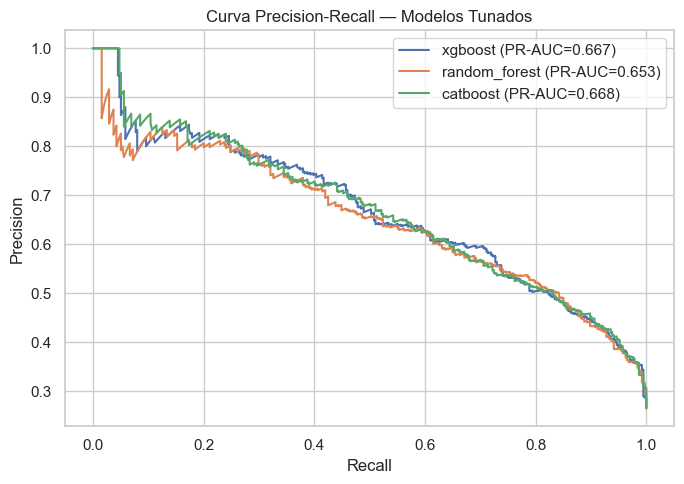

In [130]:
# Curvas PR (Tuned) — comparação visual
plt.figure(figsize=(7,5))
for alg, res in [("xgboost", res_xgb), ("random_forest", res_rf), ("catboost", res_cb)]:
    if res is None:
        continue
    prec, rec, _ = precision_recall_curve(y_test, res["test_proba"])
    pr_auc = average_precision_score(y_test, res["test_proba"])
    plt.plot(rec, prec, label=f"{alg} (PR-AUC={pr_auc:.3f})")

plt.title("Curva Precision-Recall — Modelos Tunados")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()

<a id="sec-17"></a>
## 17. Resumo final  🖥️✨

**O que entregamos (MVP completo, ponta a ponta):**
- Pipeline único e reproduzível: **EDA → preparação → treino → avaliação → tuning → calibração de threshold → serialização → API**.
- Comparação justa entre algoritmos com **o mesmo pré-processamento** (ColumnTransformer + OneHotEncoder) e o mesmo protocolo de split (**train/val/test com estratificação**).
- Foco em métrica adequada para churn (classe positiva desbalanceada): **PR-AUC (Average Precision)** como métrica principal de ranking, complementada por **Recall/F1** para análise operacional.

**Resultados (modelos Tuned no teste):**
- **CatBoost (thr_VAL=0.62)**: PR-AUC = **0.668440**, Recall = **0.676471**, F1 = **0.623153**
- **XGBoost (thr_VAL=0.60)**: PR-AUC = **0.667297**, Recall = **0.727273**, F1 = **0.636257**
- **Random Forest (thr_VAL=0.55)**: PR-AUC = **0.652624**, Recall = **0.711230**, F1 = **0.626620**

**Decisão de MVP (Hackathon): XGBoost (Tuned)**
- Embora o CatBoost tenha ficado **ligeiramente acima em PR-AUC** (diferença marginal ~0.001), o **XGBoost apresentou melhor Recall e F1**, reduzindo o risco de **Falsos Negativos** (clientes que iriam churnar e não foram priorizados).
- O XGBoost também reduz risco operacional: **dependência amplamente disponível**, pipeline serializado e **serviço FastAPI já integrado** ao artefato `churn_xgboost_pipeline_tuned.joblib`.

**Por que o threshold não é 0.5?**
- Porque **0.5 é um ponto arbitrário**. Para churn, é comum preferir **capturar mais churners (↑Recall)** mesmo com algum aumento de Falsos Positivos, alinhando a decisão ao **custo de perda do cliente** e à **capacidade de retenção** do time.

[⬆ Voltar ao Sumário](#menu)


<a id="sec-18"></a>
## 18. Storytelling do Hackathon 🎤🏁

**Contexto do problema (negócio):**
Empresas de serviços recorrentes (Telecom/Fintech/Streaming/E-commerce) sofrem quando clientes cancelam. O churn impacta diretamente **receita recorrente** e aumenta custo de aquisição. O valor do nosso MVP está em **antecipar o risco** para orientar ações de retenção com prioridade.

**Nossa solução (produto + ciência de dados):**
Construímos o **ChurnInsight**, um MVP que:
1) recebe dados do cliente (mesmo formato do dataset),  
2) calcula uma **probabilidade de churn**,  
3) aplica um **threshold calibrado**,  
4) devolve uma resposta pronta para operação: **“Vai cancelar” vs “Vai continuar”** + probabilidade.

**O diferencial técnico (o “porquê” da banca):**
- Não treinamos “um modelo qualquer”: **comparamos 3 algoritmos** (XGBoost, Random Forest, CatBoost) com o mesmo pipeline e avaliação.
- Otimizamos para churn usando **PR-AUC**, mais representativa quando a classe positiva é minoritária.
- **Calibramos o threshold no conjunto de validação** (maximizando F1), porque a decisão final depende de custo e capacidade:  
  - Se o time de retenção é pequeno → threshold mais alto (menos acionamentos, maior precisão)  
  - Se o custo do churn é alto → threshold mais baixo (mais recall, menos churn “perdido”)

**Decisão do modelo no Hackathon (clareza e pragmatismo):**
- **XGBoost (Tuned)** foi escolhido por combinar **alta capacidade preditiva** com melhor captura de churners (**Recall e F1**) e **menor risco operacional** na demo.
- O CatBoost ficou **marginalmente superior em PR-AUC**, mas a diferença é mínima e, no cenário de hackathon, priorizamos um modelo com excelente performance e integração direta com o serviço.

**O que a banca deve levar:**
Entregamos um MVP “production-like”: **modelo serializado + API FastAPI + endpoints de demo + documentação Swagger customizada**, pronto para ser acoplado a CRM/automação de retenção.

[⬆ Voltar ao Sumário](#menu)


<a id="sec-19"></a>
## 19. Script de Demonstração + Arquitetura 🧱🚀

### Arquitetura (MVP)
**1) Notebook (Treinamento e Avaliação)**
- Prepara dados, treina baselines, executa tuning com `RandomizedSearchCV` e salva artefatos `.joblib`.
- Artefato tunado inclui: `model` (Pipeline preprocess+modelo), `threshold` (cutoff do VAL), `features` e metadados (`best_params`, `best_cv_pr_auc`).

**2) Serviço de Modelo (FastAPI)**
- Carrega o artefato `model/churn_xgboost_pipeline_tuned.joblib`.
- Aplica `predict_proba` e converte probabilidade em decisão via `THRESHOLD`.
- Expõe endpoints de status, demo e predição:  
  - `GET /` (landing page de demo)  
  - `GET /health` (status do modelo + metadados)  
  - `GET /demo-examples` (3 presets: alto/baixo/inválido)  
  - `POST /predict` (endpoint principal)  
  - `GET /docs` e `GET /redoc` (documentação)

**3) UI de Demo (Landing + Swagger custom)**
- Landing page (`/`) permite executar previsões sem Swagger, com presets carregáveis.
- Swagger (`/docs`) tem CSS dark custom (`/static/swagger-dark.css`) para facilitar apresentação.

---

### Roteiro de Demonstração (3–5 minutos)
**Passo 1 — Provar que o serviço está “vivo”**
- Acesse `GET /health` e destaque:
  - `modelo_carregado: true`
  - `threshold` em uso
  - metadados do artefato (ex.: PR-AUC CV, número de features)

**Passo 2 — Mostrar os presets de demo**
- Acesse `GET /demo-examples` e explique:
  - “alto_risco”: cenário típico de churn (contrato mensal, cobrança alta, baixo tenure etc.)
  - “baixo_risco”: cenário com maior retenção (contrato longo, tenure alto etc.)
  - “invalido”: payload propositalmente errado para demonstrar validação

**Passo 3 — Executar previsões na landing**
- Acesse `/`, clique em **Prever** com “alto risco” e “baixo risco”.
- Mostre que o retorno inclui **previsão + probabilidade** e que o cutoff usa `THRESHOLD`.

**Passo 4 — Provar robustez (validação 422 simplificada)**
- Rode o preset inválido.
- Explique: para a demo, o handler retorna **“Inválido” (HTTP 422)** de forma objetiva, evitando ruído técnico na banca.

**Passo 5 — (Opcional) Executar no Swagger**
- Abra `/docs`, use **Try it out** em `POST /predict`, cole o JSON e execute.
- Isso fecha o ciclo “produto + engenharia” de forma visual.

[⬆ Voltar ao Sumário](#menu)


<a id="sec-20"></a>
## 20. README 📝✅

# ChurnInsight — MVP de Predição de Churn (Telco) com FastAPI + Modelos Tunados

O **ChurnInsight** é um MVP (Minimum Viable Product) para **predição de churn** em empresas de serviços recorrentes (Telecom, Fintech, Streaming e E-commerce).  
A solução entrega um pipeline completo: **modelagem + calibração de threshold + serialização do modelo + API para inferência**.

---

## Visão Geral
- **Problema:** reduzir cancelamentos (churn) priorizando clientes com maior risco.
- **Saída do produto:** `previsao` (Vai cancelar / Vai continuar) + `probabilidade` (0–1).
- **Diferencial:** comparação de algoritmos com o mesmo pipeline e escolha de **threshold calibrado** (não fixo em 0.5).

---

## Modelos avaliados
Foram treinados e comparados (Baseline + Tuned):
- **XGBoost**
- **Random Forest**
- **CatBoost** (opcional; depende da instalação)

A métrica principal de ranking foi **PR-AUC (Average Precision)**, adequada para churn por tratar melhor cenários com **classe positiva desbalanceada**.  
Além disso, analisamos **Recall e F1** para refletir impacto operacional (perder churners = custo alto).

---

## Decisão de MVP (modelo em produção para demo)
**Modelo selecionado:** **XGBoost (Tuned)**  
Motivos:
- Desempenho competitivo em PR-AUC e melhor equilíbrio operacional via **Recall e F1** (captura de churners).
- Integração direta com o serviço FastAPI via artefato serializado.
- Menor risco operacional para demo (dependências e portabilidade).

Artefato utilizado:
- `model/churn_xgboost_pipeline_tuned.joblib`

---

## Estrutura do repositório (sugestão)
- `data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv`  
- `notebooks/churn_modeling.ipynb` (EDA + treino + tuning + relatório)  
- `model/` (artefatos `.joblib`)  
- `ds_service/app.py` (FastAPI)  
- `ds_service/static/` (CSS do site + swagger dark)

---

## Como rodar localmente

### 1) Ambiente
Crie e ative um ambiente virtual e instale as dependências:
```bash
pip install -r requirements.txt


<a id="sec-21"></a>
## 21. Pitch para banca 🎤🧑‍🏫 — Decisão do algoritmo (MVP em produção): **XGBoost (Tuned)**

### ✅ O que entregamos
Um **MVP completo de previsão de churn**, pronto para demonstração e integração:
- Pipeline **fim a fim** (pré-processamento + modelo) serializado em `.joblib`
- **API FastAPI** com endpoint `/predict` e validação automática (Pydantic)
- Threshold **calibrado em validação** (não arbitrário) para alinhar decisão ao negócio

---

### 🔬 Como escolhemos o algoritmo (comparação justa)
Para evitar “comparação injusta”, testamos **XGBoost, CatBoost e Random Forest** sob as mesmas condições:

- Mesmo dataset e mesmas features
- Mesmo **pré-processamento (OneHot + numéricas passthrough)**
- Mesmo protocolo: **tuning com PR-AUC** + **threshold calibrado no conjunto de validação**
- Avaliação final no **mesmo conjunto de teste** (holdout)

---

### 📊 Resultado objetivo (por que XGBoost?)
Mesmo com **PR-AUC** muito próximo entre os melhores:

- CatBoost Tuned: **PR-AUC = 0.6684**
- XGBoost Tuned: **PR-AUC = 0.6673**
- Diferença: **~0.001** (marginal, plausível por variação de split/seed)

➡️ **Em churn, o custo de errar um churner é alto** (FN = cliente cancela e o modelo “não viu”).  
Por isso, priorizamos **captura de churners** com bom equilíbrio de erro:

- **Recall (XGBoost): 0.7273** → melhor para reduzir **Falsos Negativos**
- **F1 (XGBoost): 0.6363** → melhor equilíbrio geral (precision vs recall)

✅ **Decisão final**: XGBoost (Tuned) por **melhor Recall + melhor F1**, mantendo PR-AUC competitivo.

---

### 🧠 Por que isso importa para o negócio?
- **Menos falsos negativos** = mais clientes “em risco” identificados a tempo  
- Permite priorizar ações de retenção com foco em impacto (ex.: bônus, upgrade, suporte proativo)
- Threshold calibrado = a operação define o “volume” de clientes acionados de acordo com a capacidade do time

---

### 🚀 Por que é a melhor escolha para a demo do hackathon?
Além de desempenho, priorizamos **confiabilidade e entregabilidade**:

- **XGBoost já está integrado** ao pipeline serializado e à API
- Menor risco operacional (menos dependências e menos variáveis na demo)
- Demonstra maturidade técnica: **treino → tuning → serialização → inferência via API**

---

[⬆ Voltar ao Sumário](#menu)


<a id="sec-23"></a>
## 22. Exemplos de requisição (payloads) 🧪📨
3 presets com (alto/baixo/inválido) para ser validaco com FastAPI.

### ### 🔴 Alto risco

```json
{
  "gender": "Female",
  "SeniorCitizen": 0,
  "Partner": "Yes",
  "Dependents": "No",
  "tenure": 1,
  "PhoneService": "Yes",
  "MultipleLines": "No",
  "InternetService": "Fiber optic",
  "OnlineSecurity": "No",
  "OnlineBackup": "Yes",
  "DeviceProtection": "No",
  "TechSupport": "No",
  "StreamingTV": "Yes",
  "StreamingMovies": "No",
  "Contract": "Month-to-month",
  "PaperlessBilling": "Yes",
  "PaymentMethod": "Electronic check",
  "MonthlyCharges": 99,
  "TotalCharges": 99
}
```

#### Resposta: 
HTTP 200

{
  "previsao": "Vai cancelar",
  "probabilidade": 0.9312185049057007
}


### 🟢 Baixo risco

```json
{
  "gender": "Female",
  "SeniorCitizen": 0,
  "Partner": "Yes",
  "Dependents": "No",
  "tenure": 1,
  "PhoneService": "Yes",
  "MultipleLines": "No",
  "InternetService": "Fiber optic",
  "OnlineSecurity": "No",
  "OnlineBackup": "Yes",
  "DeviceProtection": "No",
  "TechSupport": "No",
  "StreamingTV": "Yes",
  "StreamingMovies": "No",
  "Contract": "Month-to-month",
  "PaperlessBilling": "Yes",
  "PaymentMethod": "Electronic check",
  "MonthlyCharges": 99,
  "TotalCharges": 99
}
```

#### Resposta: 
HTTP 200

{
  "previsao": "Vai continuar",
  "probabilidade": 0.05352236330509186
}


### ⚠️ Inválido

```json

{
  "gender": "Female",
  "SeniorCitizen": 0,
  "Partner": "Yes",
  "Dependents": "No",
  "tenure": 1,
  "PhoneService": "Yes",
  "MultipleLines": "No",
  "InternetService": "Fiber optic",
  "OnlineSecurity": "No",
  "OnlineBackup": "Yes",
  "DeviceProtection": "No",
  "TechSupport": "No",
  "StreamingTV": "Yes",
  "StreamingMovies": "No",
  "Contract": "Month-to-month",
  "PaperlessBilling": "Yes",
  "PaymentMethod": "Electronic check",
  "MonthlyCharges": 99,
  "TotalCharges": 99
}
```
#### Resposta:
HTTP 422

Inválido

[⬆ Voltar ao Sumário](#menu)

<a id="sec-24"></a>
## 23. Testes via cURL (FastAPI / Spring Boot) 🧰🧪

Esta seção reúne comandos **cURL prontos** para validar o serviço **sem depender do Swagger/UI**.  
A ideia é ter um “plano B” rápido para demonstração e para debug: você envia um JSON e confirma se a API retorna **HTTP 200** (válidos) e **HTTP 422** (inválido).

### 23.1 Variáveis de ambiente (recomendado)
Defina o host/porta uma vez e reutilize nos comandos abaixo.

```bash
# FastAPI (local)
BASE_URL="http://localhost:8000"

# Se estiver em outro host/porta, ajuste aqui:
# BASE_URL="http://127.0.0.1:8000"


<a id="sec-25"></a>
## 24. Padrão de erro + Checklist de demo ✅

Esta seção define um **padrão de respostas de erro** e um **checklist objetivo** para garantir que a demo do hackathon seja previsível, rápida e “à prova de banca”. O foco é: mostrar valor (modelo funcionando), robustez (validação e erros controlados) e rastreabilidade (logs e versão do artefato).

---

### 24.1 Padrão de erro (contrato da API)

#### 422 — Entrada inválida (Pydantic)
Quando o JSON estiver com **campo faltando**, **tipo incorreto** (ex.: `tenure="doze"`) ou **valor fora do esperado**, o serviço retorna:

- **HTTP 422**
- Corpo simplificado: **`Inválido`**

Motivo: na demo, isso reduz ruído e deixa claro que existe validação no endpoint. O detalhe completo do erro fica nos logs do servidor (para debug).

#### 500 — Erro interno (modelo/artefato/execução)
Se houver problema de infraestrutura (modelo não carregou, artefato ausente, incompatibilidade de pipeline), o endpoint pode responder:

- **HTTP 500**
- Mensagem de erro (para diagnóstico)

Recomendação: antes de apresentar, valide o serviço via `/health` para evitar esse cenário.

---

### 24.2 Rastreabilidade: request_id e logs
Para auditoria rápida durante a demo e troubleshooting (principalmente quando há múltiplas chamadas), padronize um **request_id** por requisição.

**Boas práticas:**
- Aceitar `X-Request-ID` no header (se o cliente enviar) ou gerar um UUID no backend.
- Logar no console (ou arquivo) pelo menos:
  - `request_id`
  - método + path (`POST /predict`)
  - status HTTP (200/422/500)
  - tempo de resposta (ms)
  - (opcional) `probabilidade` e `previsao` para casos válidos, sem expor PII

> Resultado esperado na banca: você consegue dizer “esta chamada foi a request X, retornou 422 por causa de tenure string” sem perder tempo.

---

### 24.3 Checklist rápido de demo (roteiro “sem falhas”)

#### Antes da demo (pré-flight – 1 minuto)
- [ ] Iniciar a API (`uvicorn ...`) sem erros.
- [ ] Abrir `GET /health` e confirmar:
  - [ ] `status: ok`
  - [ ] `modelo_carregado: true`
  - [ ] `threshold` exibido (ex.: `0.60`)
  - [ ] `modelo_path` correto (apontando para `churn_xgboost_pipeline_tuned.joblib`)
- [ ] Confirmar que existe o arquivo do artefato em `../model/` no repo.

#### Durante a demo (30–60 segundos)
- [ ] **Caso 1 (🛑 Alto risco)**: enviar preset alto risco → **HTTP 200** + `"Vai cancelar"` + probabilidade alta.
- [ ] **Caso 2 (🟢 Baixo risco)**: enviar preset baixo risco → **HTTP 200** + `"Vai continuar"` + probabilidade baixa.
- [ ] **Caso 3 (⚠️ Inválido)**: enviar JSON inválido → **HTTP 422** + `Inválido` (prova de validação).

#### Evidência técnica (credibilidade)
- [ ] Mostrar (na landing page ou no `/health`) o **modelo em uso**, o **threshold** e a **versão do artefato**:
  - modelo: `XGBoost Tuned`
  - threshold: `thr_VAL=...`
  - (opcional) `best_cv_pr_auc` e `best_params`

---

### 24.4 O que a banca deve ver (mensagem principal)
1. **Funciona ponta a ponta**: payload → API → modelo → resposta.
2. **É robusto**: validação 422 e erros controlados.
3. **É reproduzível**: modelo/threshold/artefato versionados e rastreáveis.

[⬆ Voltar ao Sumário](#menu)


# Breve explicação 
## ChurnInsight — Por que testamos 3 modelos e como tudo se conecta (resumo para o time)

## 1) Por que testar **3 modelos diferentes** (XGBoost, Random Forest, CatBoost)?
- **Evita “apostar no escuro”**: modelos diferentes aprendem padrões de formas diferentes.
- **Comparação justa**: com o mesmo dataset, mesmo pré-processamento e mesma avaliação, descobrimos qual entrega melhor resultado.
- **Decisão baseada em dados**: escolhemos o modelo com melhor performance para churn (ex.: PR-AUC/Recall/F1), não por preferência.

Resultado prático: temos evidência de que o modelo escolhido é a melhor opção **para esse problema e esse dataset**.

---

## 2) O que significa **serializar o melhor modelo**?
Serializar é “salvar” o modelo treinado (junto com o pipeline de pré-processamento e threshold) em um arquivo, por exemplo:
- `../model/churn_xgboost_pipeline_tuned.joblib`

Por que isso é importante?
- **Reprodutibilidade**: o mesmo modelo que foi avaliado é o que vai para produção/demo.
- **Portabilidade**: o serviço (API) carrega o arquivo e já consegue prever sem re-treinar.
- **MVP mais estável**: evita variações de resultados por treino “na hora”.

---

## 3) Onde entra a **FastAPI**?
A FastAPI é o **serviço de inferência** (o “microserviço do modelo”):
- Carrega o modelo serializado no startup
- Recebe um JSON com os dados do cliente (`POST /predict`)
- Retorna a previsão e a probabilidade, por exemplo:
  - `"Vai cancelar"` / `"Vai continuar"`
  - `probabilidade: 0.93`

Função da FastAPI: ser o **ponto único** e padronizado para fazer previsões.

---

## 4) E o **Java/Spring Boot**?
O Spring Boot é a camada de **produto/negócio** (API principal do sistema).
Ele pode:
- Chamar a FastAPI para obter a previsão de churn
- Registrar logs, auditoria e eventos (ex.: “cliente marcado como risco alto”)
- Integrar com CRM/marketing/suporte
- Aplicar regras do negócio (ex.: “se risco alto → abrir ticket”, “se risco médio → enviar oferta”, etc.)

Resumo: Spring Boot “orquestra” o processo de retenção; FastAPI “calcula” a previsão.

---

## 5) Como essas partes se conectam (fluxo simples)
- **Notebook (Treino/Validação)**
  - Treina 3 modelos → escolhe o melhor → salva (`.joblib`)
- **FastAPI (Modelo em produção)**
  - Carrega o `.joblib` → expõe `/predict` para prever churn
- **Spring Boot (Aplicação do produto)**
  - Consome `/predict` → toma decisões e integra com sistemas

---

## 6) Um mapa mental rápido
- Notebook = **constrói e valida o modelo**
- Serialização = **empacota o modelo pronto**
- FastAPI = **serve a previsão via HTTP**
- Spring Boot = **usa a previsão para ação de negócio**
